<a href="https://colab.research.google.com/github/ErdemKilci/ReservoirWind/blob/main/reservoir_wind.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Power Consumption Forecasting Project

## Project Goal:
This project aims to analyze and model power consumption based on actual and forecasted loads using machine learning.

## Data Source:
- **Time**
- **Forecast Load**
- **Actual Load**

## Steps Taken So Far:
1. **Data Loading**
2. **Data Cleaning**
3. **Missing Values Analysis**
4. **Basic Data Visualization**
5. **Time-Series Plots**
6. **Error Analysis**

In [1]:
pip install pandas matplotlib openpyxl plotly ipywidgets seaborn scipy statsmodels scikit-learn 


Note: you may need to restart the kernel to use updated packages.


## Data Loading and Cleaning
### Goal:
- Read all Excel files
- Merge them into one dataset
- Remove unnecessary rows
- Rename columns
- Convert data types

### Code:

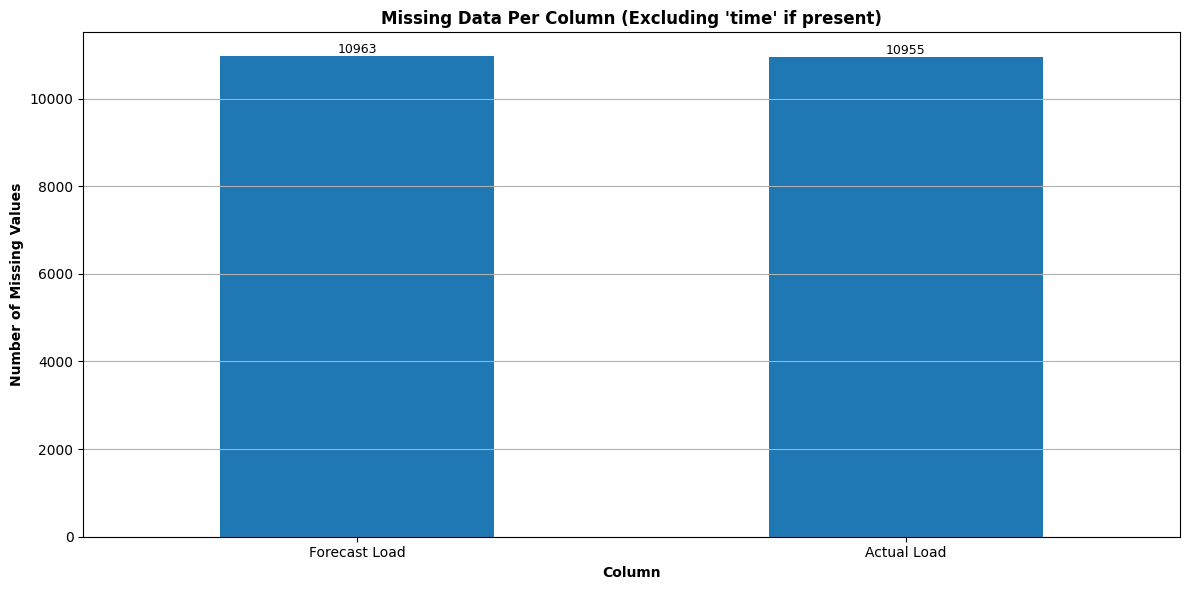

Missing Values Count (Raw Data):
 Time              7296
Forecast Load    10963
Actual Load      10955
dtype: int64

Missing Values Percentage (Raw Data):
 Time              7.398019
Forecast Load    11.116294
Actual Load      11.108182
dtype: float64
Time range in data: 2015-01-01 00:00:00 to 2024-12-31 23:00:00


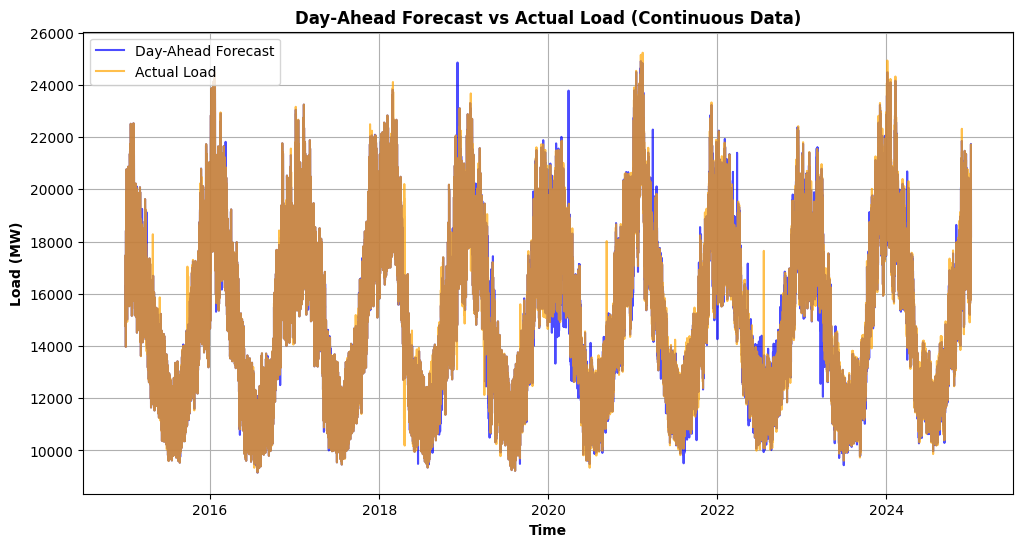

'\nimport pandas as pd\nimport os\nimport matplotlib.pyplot as plt\n\n# Example for file path\ndata_folder = "Data"\nexcel_files = sorted([f for f in os.listdir(data_folder) if f.endswith(\'.xlsx\')])  # Sort files chronologically\n\nall_data = pd.DataFrame()\n\n# Manually define the initial start date\ncurrent_datetime = pd.Timestamp("2014-01-01 00:00:00")  # Adjust based on the first file\n\nfor file in excel_files:\n    file_path = os.path.join(data_folder, file)\n    # Read Excel file\n    data = pd.read_excel(file_path, skiprows=7)  # Skip metadata rows\n\n    # Rename columns\n    data.columns = [\'Time\', \'Forecast Load\', \'Actual Load\']\n\n    # Use a counter to process 24 rows and skip the next 3 rows, with reset logic\n    filtered_data = pd.DataFrame()\n    count = 0  # Counter for rows\n    skip = 1  # Tracks rows to be skipped\n\n    for index, row in data.iterrows():\n        # If we are in the skipping phase, decrement the skip counter and continue\n        if skip > 

In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import re
import seaborn as sns

# Define file paths
data_folder = "Data"
excel_files = sorted([f for f in os.listdir(data_folder) if f.endswith('.xlsx')])  # Sort files chronologically

raw_data_list = [] # To store raw data for vis..
all_data = pd.DataFrame() # This will store the cleaned data.

for file in excel_files:
    file_path = os.path.join(data_folder, file)

    # Extract year from filename (filename is just "2014.xlsx", "2015.xlsx", etc.)
    file_year = os.path.splitext(file)[0]  # Removes .xlsx and takes only the year

    # Read Excel file, skipping 6 rows
    data = pd.read_excel(file_path, skiprows=6, dtype=str)

        #Cleaning process
    # Rename first row as actual column names
    data.columns = ['Time', 'Forecast Load', 'Actual Load']

    # Store a copy of the raw data after column rename (before further cleaning)
    raw_data_list.append(data.copy())


    #Cleaning process
    # Rename first row as actual column names
    data.columns = ['Time', 'Forecast Load', 'Actual Load']
    
    # Rename second row with year-specific timestamp
    data.iloc[0] = [f'01.01.{file_year}', '', '']

    # Drop fully empty rows
    data = data.dropna(how='all')

    # Identify rows with date markers (xx.xx.xxxx format)
    date_mask = data['Time'].str.match(r'\d{2}\.\d{2}\.\d{4}', na=False)
    data['Is_Date'] = date_mask
    
    # Fill forward the date values
    data['Date'] = data.loc[data['Is_Date'], 'Time']
    data['Date'] = data['Date'].ffill()
    
    # Remove the rows that contain only the date markers
    data = data[~data['Is_Date']]
    
    # Convert "Time" format from "HH:MM - HH:MM" to just "HH:MM"
    data['Time'] = data['Time'].str.split(' - ').str[0]
    
    # Combine Date and Time to create full timestamp
    data['Timestamp'] = pd.to_datetime(data['Date'] + ' ' + data['Time'], format='%d.%m.%Y %H:%M', errors='coerce')
    
    # Convert Forecast and Actual Load to numeric, handling errors
    data['Forecast Load'] = pd.to_numeric(data['Forecast Load'], errors='coerce')
    data['Actual Load'] = pd.to_numeric(data['Actual Load'], errors='coerce')

    # Append cleaned data
    all_data = pd.concat([all_data, data[['Timestamp', 'Forecast Load', 'Actual Load']]], ignore_index=True)

# Combine all raw data for visualization
raw_data = pd.concat(raw_data_list, ignore_index=True)

# Exclude any columns that start with 'Unnamed'
# Strip any whitespace around column names
raw_data.columns = raw_data.columns.str.strip()
# Drop columns containing 'Unnamed' in the name
raw_data = raw_data.loc[:, ~raw_data.columns.str.contains('^Unnamed', case=False)]

# Visualize missing values in raw data (before cleaning), row by row
# Prepare raw data for visualization (before cleaning)

# Reset index for clarity
raw_data_reset = raw_data.reset_index(drop=True)

# Select only relevant columns
raw_data_vis = raw_data_reset[['Forecast Load', 'Actual Load']].copy()

# Convert to NaN where applicable (just in case some empty strings remain)
raw_data_vis.replace('', np.nan, inplace=True)

# Drop 'time' column only if it exists
columns = raw_data_vis.columns.drop('time', errors='ignore')

# Calculate number of missing values per column (excluding 'time' if present)
missing_per_column = raw_data_vis[columns].isnull().sum()

# Plot
plt.figure(figsize=(12, 6))
ax = missing_per_column.plot(kind='bar', stacked=False)
plt.title("Missing Data Per Column (Excluding 'time' if present)", fontweight = 'bold')
plt.ylabel("Number of Missing Values", fontweight = 'bold')
plt.xlabel("Column", fontweight = 'bold')
plt.grid(axis='y')
plt.xticks(rotation=360)
plt.tight_layout()

# Add exact numbers on top of each bar
for i, value in enumerate(missing_per_column):
    ax.text(i, value + 0.5, str(value), ha='center', va='bottom', fontsize=9)
plt.savefig("raw_empty_row.pdf", dpi=300, format="pdf")
plt.show()



#Print missing values counts and percentages for raw data
missing_counts = raw_data.isnull().sum()
missing_percent = raw_data.isnull().mean()*100
print("Missing Values Count (Raw Data):\n", missing_counts)
print("\nMissing Values Percentage (Raw Data):\n", missing_percent)

# After: Visualise Cleaned Data

# Verify the range of the data
print("Time range in data:", all_data['Timestamp'].min(), "to", all_data['Timestamp'].max())

# Plot the data, ensuring no missing hours
plt.figure(figsize=(12, 6))
plt.plot(all_data['Timestamp'], all_data['Forecast Load'], label='Day-Ahead Forecast', alpha=0.7, color='blue')
plt.plot(all_data['Timestamp'], all_data['Actual Load'], label='Actual Load', alpha=0.7, color='orange')
plt.xlabel('Time', fontweight = 'bold')
plt.ylabel('Load (MW)', fontweight = 'bold')
plt.title('Day-Ahead Forecast vs Actual Load (Continuous Data)', fontweight = 'bold')
plt.savefig("time_series.pdf", dpi=300, format="pdf")
plt.legend()
plt.grid()
plt.show()

'''
# --- **INSERT CODE FOR HANDLING MISSING LAST TWO MONTHS HERE** ---
last_year_data = all_data['Timestamp'].dt.year.max() # Identify the last year in your data
missing_months = [10, 11, 12] # November and December

# 1. Identify timestamps for the missing last two months of the last year
start_missing_date = pd.to_datetime(f'2024-10-31 11:00:00')
end_missing_date = pd.to_datetime(f'{last_year_data}-12-31 23:00:00')
missing_timestamps = pd.date_range(start=start_missing_date, end=end_missing_date, freq='H') # Hourly timestamps

# 2. Filter historical data (excluding the last year) and for Nov/Dec
historical_data = all_data[all_data['Timestamp'].dt.year < 2024]
historical_nov_dec = historical_data[historical_data['Timestamp'].dt.month.isin(missing_months)]

# 3. Calculate average hourly load for Nov/Dec across historical years
average_hourly_load = historical_nov_dec.groupby(historical_nov_dec['Timestamp'].dt.hour).agg(
    {'Forecast Load': 'mean', 'Actual Load': 'mean'}
).rename(columns={'Forecast Load': 'Avg Forecast Load', 'Actual Load': 'Avg Actual Load'})

# 4. Create a DataFrame for the missing months with imputed values
imputed_data_list = []
for ts in missing_timestamps:
    hour = ts.hour
    if hour in average_hourly_load.index: # Make sure hour exists in average data (should always be true for hourly data)
        imputed_data_list.append({
            'Timestamp': ts,
            'Forecast Load': average_hourly_load.loc[hour, 'Avg Forecast Load'],
            'Actual Load': average_hourly_load.loc[hour, 'Avg Actual Load']
        })

imputed_data_df = pd.DataFrame(imputed_data_list)

# 5. Concatenate imputed data with the original all_data
all_data = pd.concat([all_data, imputed_data_df], ignore_index=True)

# Sort by timestamp to maintain chronological order
all_data = all_data.sort_values(by='Timestamp').reset_index(drop=True)

# Verify the range of the data *after* imputation
print("Time range in data after imputation:", all_data['Timestamp'].min(), "to", all_data['Timestamp'].max())


# Plot the data, ensuring no missing hours
plt.figure(figsize=(12, 6))
plt.plot(all_data['Timestamp'], all_data['Forecast Load'], label='Day-Ahead Forecast', alpha=0.7, color='blue')
plt.plot(all_data['Timestamp'], all_data['Actual Load'], label='Actual Load', alpha=0.7, color='orange')
plt.xlabel('Time')
plt.ylabel('Load (MW)')
plt.title('Day-Ahead Forecast vs Actual Load (Continuous Data)')
plt.legend()
plt.grid()
plt.show()
'
'''


# Old Code
"""
import pandas as pd
import os
import matplotlib.pyplot as plt

# Example for file path
data_folder = "Data"
excel_files = sorted([f for f in os.listdir(data_folder) if f.endswith('.xlsx')])  # Sort files chronologically

all_data = pd.DataFrame()

# Manually define the initial start date
current_datetime = pd.Timestamp("2014-01-01 00:00:00")  # Adjust based on the first file

for file in excel_files:
    file_path = os.path.join(data_folder, file)
    # Read Excel file
    data = pd.read_excel(file_path, skiprows=7)  # Skip metadata rows

    # Rename columns
    data.columns = ['Time', 'Forecast Load', 'Actual Load']

    # Use a counter to process 24 rows and skip the next 3 rows, with reset logic
    filtered_data = pd.DataFrame()
    count = 0  # Counter for rows
    skip = 1  # Tracks rows to be skipped

    for index, row in data.iterrows():
        # If we are in the skipping phase, decrement the skip counter and continue
        if skip > 0:
            skip -= 1
            continue

        # Include the current row in the filtered_data
        filtered_data = pd.concat([filtered_data, pd.DataFrame([row])])
        count += 1

        # Once 24 rows are processed, skip the next 3 rows and reset the counter
        if count == 24:
            skip = 3  # Set skip counter for the next 3 rows
            count = 0  # Reset the counter

    # Generate timestamps dynamically based on the current_datetime
    num_rows = len(filtered_data)
    time_range = pd.date_range(start=current_datetime, periods=num_rows, freq='h')
    filtered_data['Time'] = time_range

    # Update current_datetime to continue from the end of this file's data
    current_datetime = time_range[-1] + pd.Timedelta(hours=1)

    # Convert columns to numeric, preserving NaN values
    filtered_data['Forecast Load'] = pd.to_numeric(filtered_data['Forecast Load'], errors='coerce')
    filtered_data['Actual Load'] = pd.to_numeric(filtered_data['Actual Load'], errors='coerce')

    # Append to the combined DataFrame
    all_data = pd.concat([all_data, filtered_data[['Time', 'Forecast Load', 'Actual Load']]], ignore_index=True)

# Verify the range of the data
print("Time range in data:", all_data['Time'].min(), "to", all_data['Time'].max())

# Plot the data, including null values
plt.figure(figsize=(12, 6))
plt.plot(all_data['Time'], all_data['Forecast Load'], label='Day-Ahead Forecast', alpha=0.7, color='blue')
plt.plot(all_data['Time'], all_data['Actual Load'], label='Actual Load', alpha=0.7, color='orange')
plt.xlabel('Time')
plt.ylabel('Load (MW)')
plt.title('Day-Ahead Forecast vs Actual Load (With Skipped Rows)')
plt.legend()
plt.grid()
plt.show()
"""


## Data Visualization

### Plots Created:
1. Forecast vs Actual Load (Time Series)
2. Yearly Trend Analysis
3. Forecast Error Over Time
4. Missing Data Heatmap


In [3]:
print(data.head())       # Check first few rows
print(data.describe())   # Statistical summary
print(data.isnull().sum())  # Missing values


    Time  Forecast Load  Actual Load  Is_Date        Date           Timestamp
1  00:00        17872.0      18350.0    False  01.01.2024 2024-01-01 00:00:00
2  01:00        18118.0      18364.0    False  01.01.2024 2024-01-01 01:00:00
3  02:00        17993.0      18224.0    False  01.01.2024 2024-01-01 02:00:00
4  03:00        17851.0      18030.0    False  01.01.2024 2024-01-01 03:00:00
5  04:00        17827.0      18009.0    False  01.01.2024 2024-01-01 04:00:00
       Forecast Load   Actual Load                      Timestamp
count    8784.000000   8784.000000                           8785
mean    15554.240779  15577.568420  2024-07-01 23:49:11.713147648
min      9965.000000   9862.000000            2024-01-01 00:00:00
25%     12759.750000  12841.750000            2024-04-01 12:00:00
50%     15250.000000  15228.500000            2024-07-02 00:00:00
75%     17989.500000  17962.000000            2024-10-01 12:00:00
max     24480.000000  24930.000000            2024-12-31 23:00:00
std 

### Analyse Data Each Year

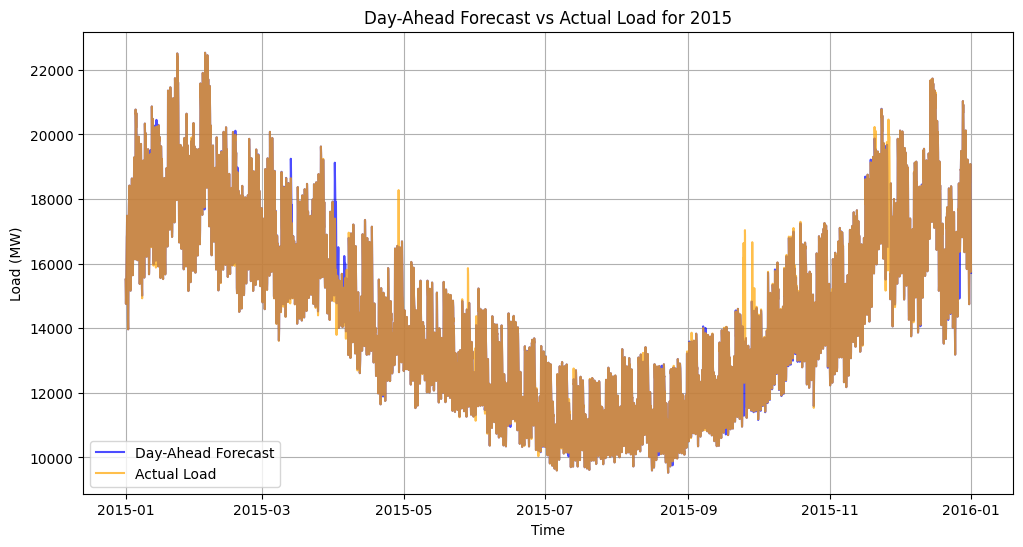

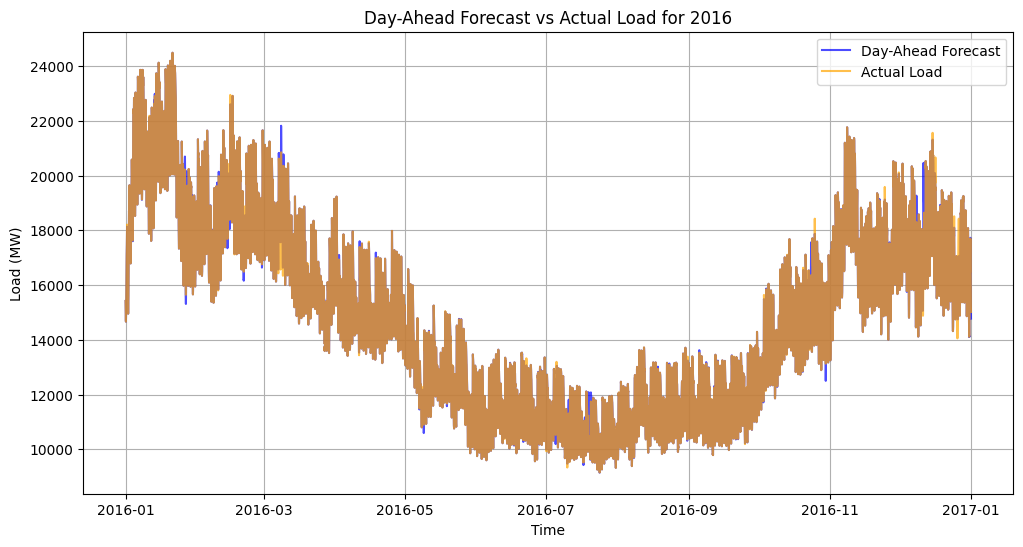

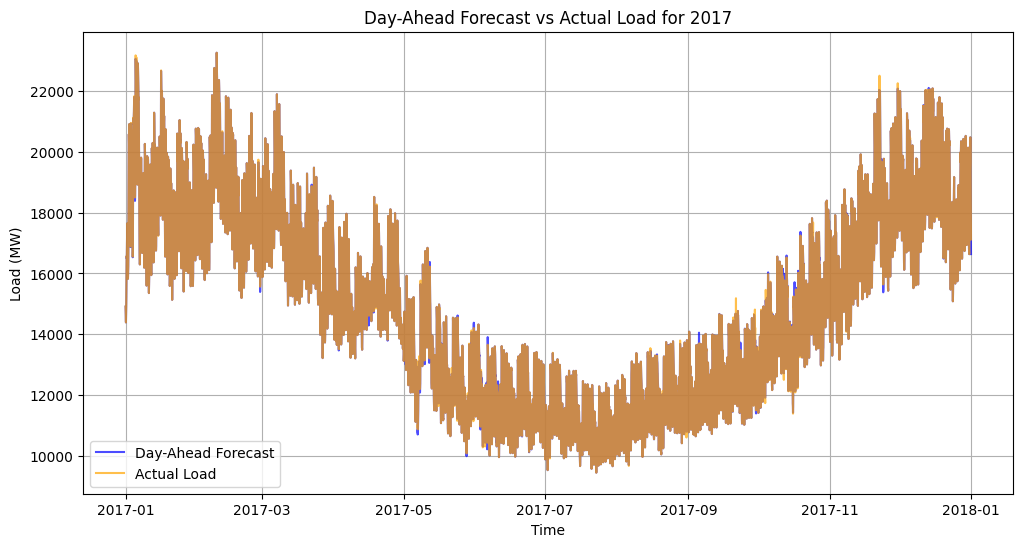

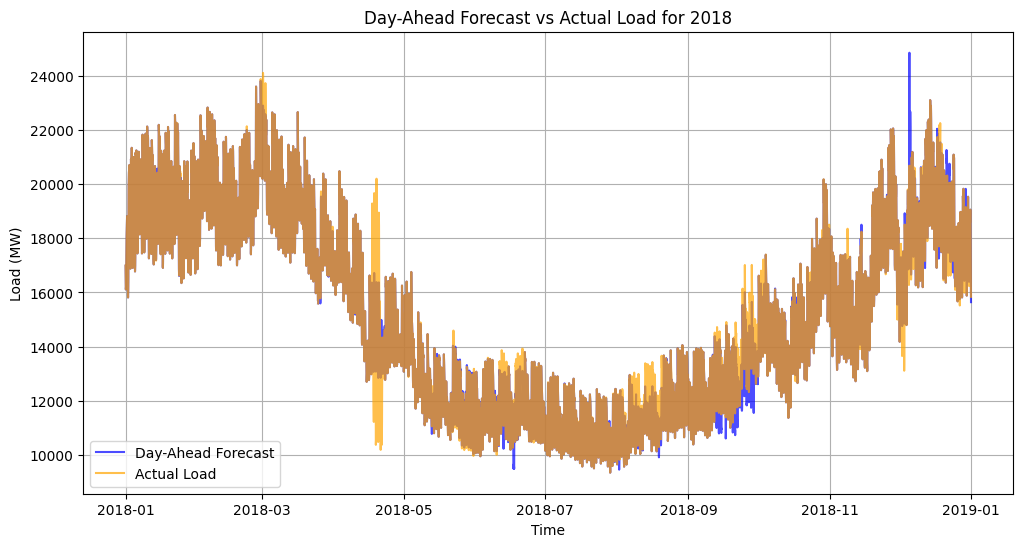

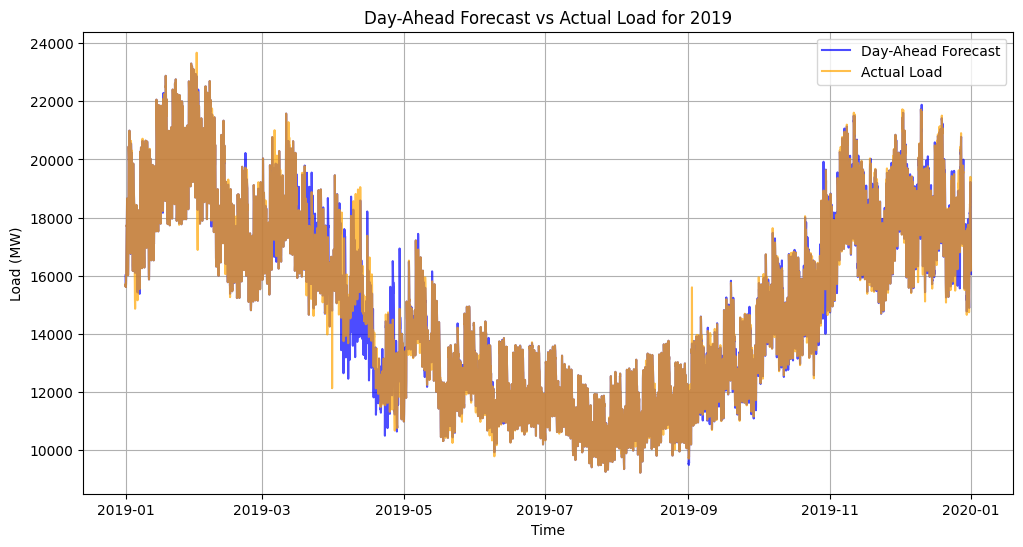

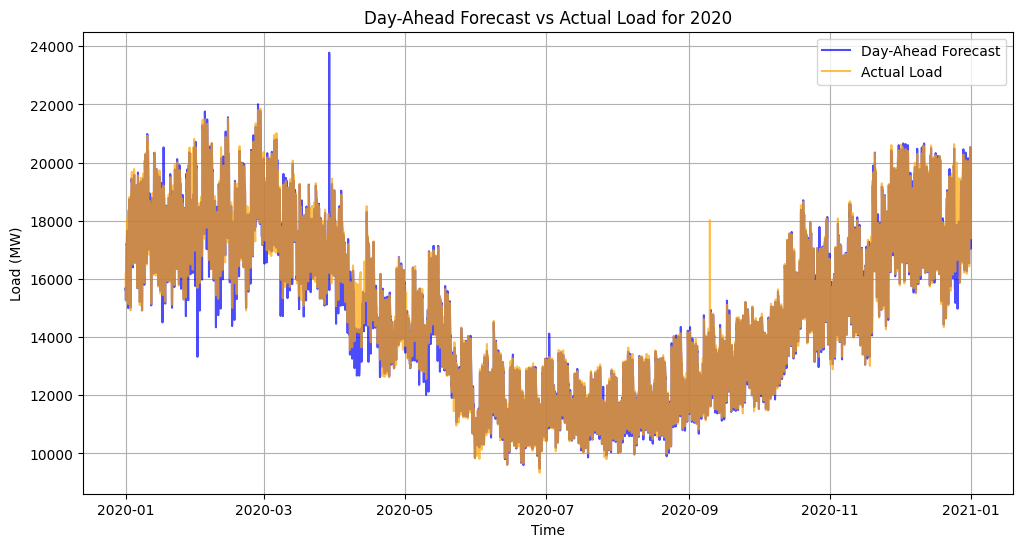

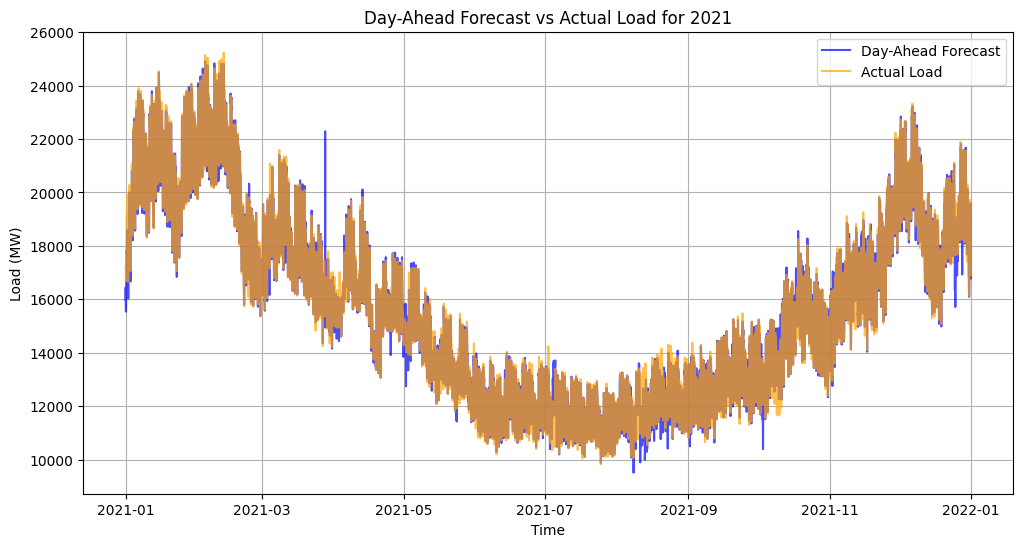

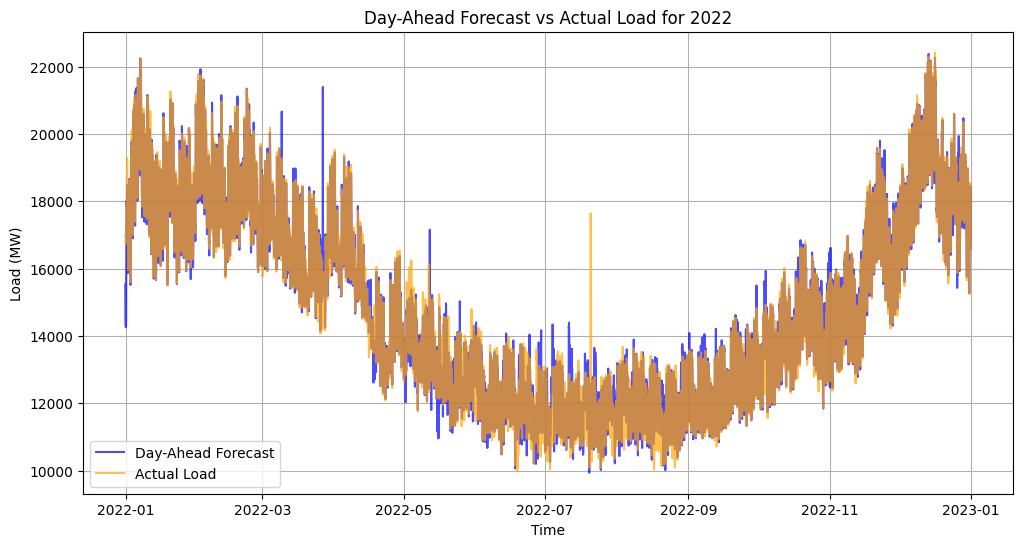

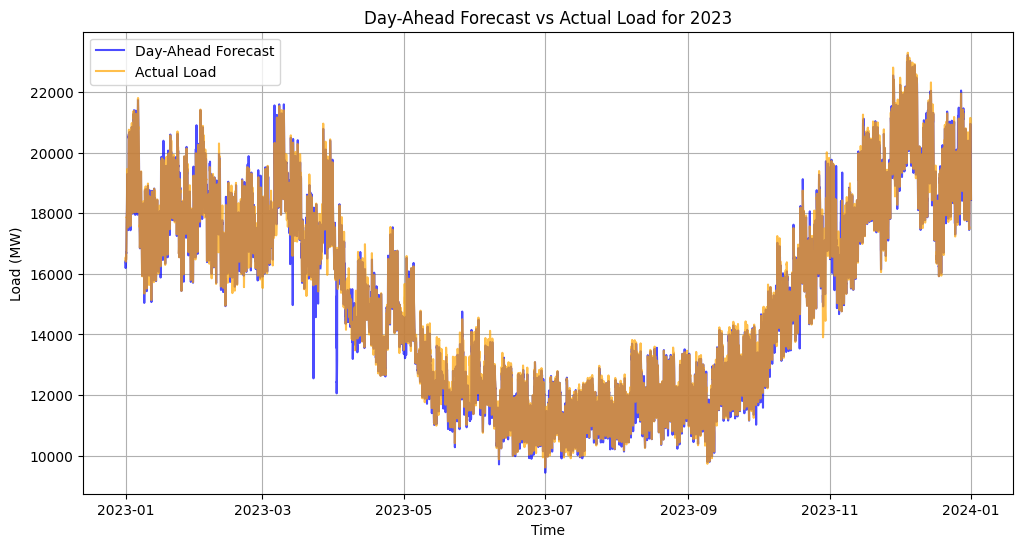

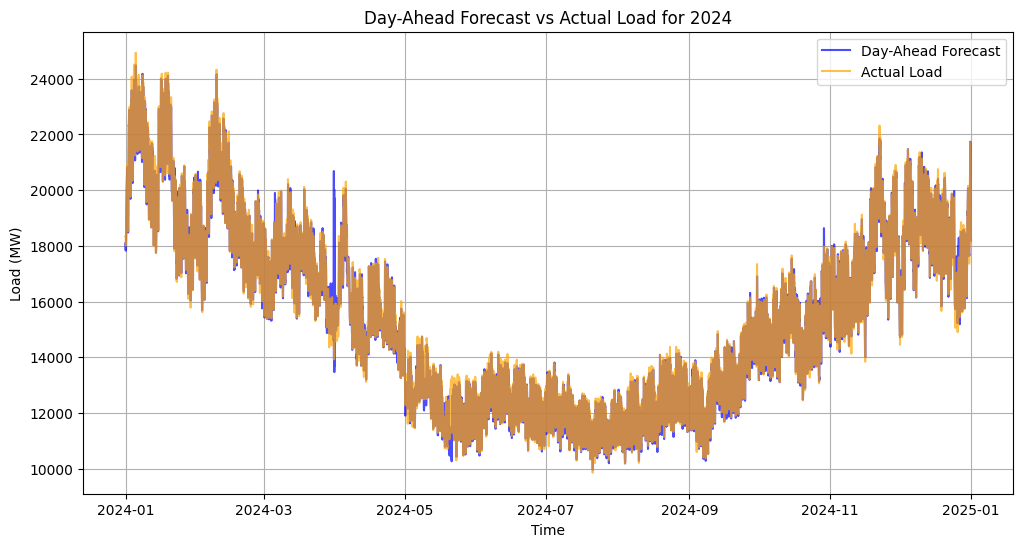

In [4]:
# Group data by year
for year, year_data in all_data.groupby(all_data['Timestamp'].dt.year):
    plt.figure(figsize=(12, 6))
    plt.plot(year_data['Timestamp'], year_data['Forecast Load'], label='Day-Ahead Forecast', alpha=0.7, color='blue')
    plt.plot(year_data['Timestamp'], year_data['Actual Load'], label='Actual Load', alpha=0.7, color='orange')
    plt.xlabel('Time')
    plt.ylabel('Load (MW)')
    plt.title(f'Day-Ahead Forecast vs Actual Load for {year}')
    plt.legend()
    plt.grid()
    plt.show()


## Exploratory Data Analysis (EDA)

### What we analyzed:
- Summary statistics
- Missing values
- Time range verification

### Summary Statistics

In [5]:
# Ensure 'Timestamp' is in datetime format
all_data['Year'] = all_data['Timestamp'].dt.year  # Extract the year

# Group by year and calculate statistics
summary_stats = all_data.groupby('Year').agg({
    'Forecast Load': ['mean', 'max', 'min'],
    'Actual Load': ['mean', 'max', 'min']
})

# Print summary statistics
print(summary_stats)




     Forecast Load                    Actual Load                 
              mean      max     min          mean      max     min
Year                                                              
2015  14679.735119  22531.0  9527.0  14689.310388  22530.0  9527.0
2016  15073.934882  24485.0  9147.0  15070.784101  24485.0  9157.0
2017  15170.839155  23246.0  9458.0  15169.687215  23246.0  9457.0
2018  15400.935388  24854.0  9342.0  15467.212557  24108.0  9343.0
2019  15224.333447  23300.0  9217.0  15236.381963  23672.0  9217.0
2020  15100.248634  23779.0  9476.0  15125.462090  21861.0  9338.0
2021  15831.555708  24911.0  9508.0  15857.231735  25230.0  9820.0
2022  15015.697146  22379.0  9938.0  15023.900457  22416.0  9992.0
2023  15312.009932  23229.0  9435.0  15352.816210  23305.0  9608.0
2024  15554.240779  24480.0  9965.0  15577.568420  24930.0  9862.0


### Comment Summary stats
burasini inceledigmizde goruyoruz ki 2014 yilinin gunde en az harcandigi enerji miktarri 14295.0
lakin diger yillara baktigimizda 2015 ve sonrasi icin geneli 9500 kusurde. Bunun nedeni 2014 yilinin sadece aralik ayinin degerlendirilmesi diger verilerin olmamasi yani yaz ve kis kiyaslamasi yok.



### Saving Processed Data

In [6]:
all_data.to_csv('combined_data.csv', index=False)


### Missing Data HeatMap

<Figure size 1200x600 with 0 Axes>

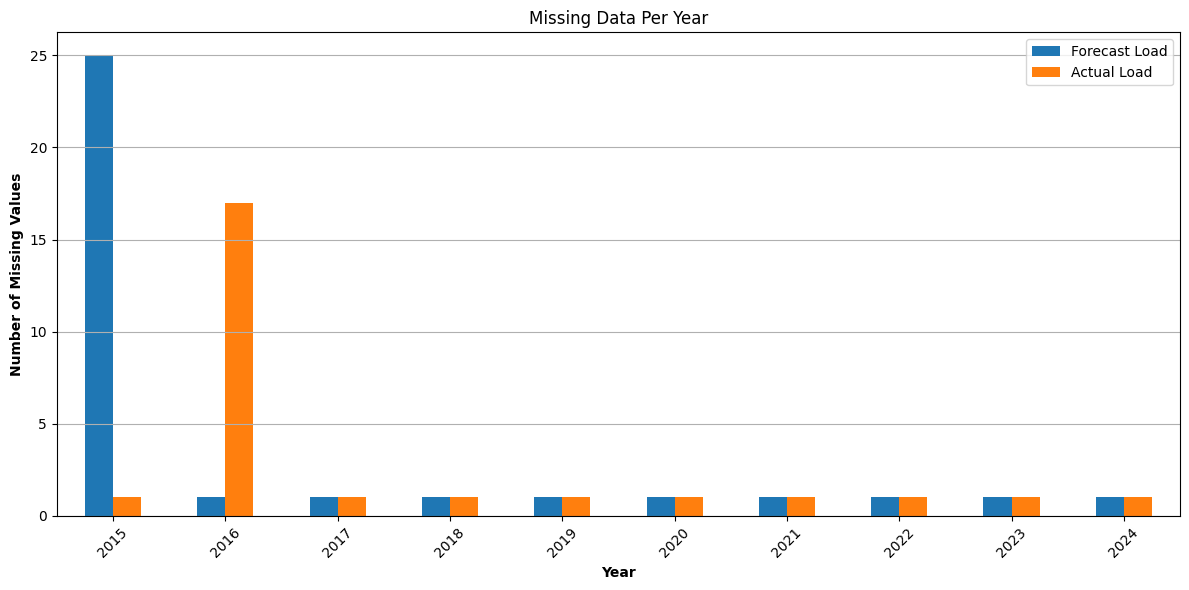

=== Missing Values by Year ===
       Timestamp  Forecast Load  Actual Load  Year
2015           0             25            1     0
2016           0              1           17     0
2017           0              1            1     0
2018           0              1            1     0
2019           0              1            1     0
2020           0              1            1     0
2021           0              1            1     0
2022           0              1            1     0
2023           0              1            1     0
2024           0              1            1     0
Total          0             34           26     0

=== Detailed Missing Values with Timestamps ===
        Year           Timestamp         Column
2090    2015 2015-03-29 02:00:00  Forecast Load
7897    2015 2015-11-26 00:00:00  Forecast Load
7898    2015 2015-11-26 01:00:00  Forecast Load
7899    2015 2015-11-26 02:00:00  Forecast Load
7900    2015 2015-11-26 03:00:00  Forecast Load
7901    2015 2015-11

In [7]:
import matplotlib.pyplot as plt

# Group by year and count missing values
missing_by_year = all_data.groupby(all_data['Timestamp'].dt.year)[['Forecast Load', 'Actual Load']].apply(lambda x: x.isnull().sum())

# Drop NaN years (if Timestamp was NaT)
missing_by_year = missing_by_year.dropna()

# Plot
plt.figure(figsize=(12, 6))
missing_by_year.plot(kind='bar', stacked=False, figsize=(12, 6))

plt.title("Missing Data Per Year")
plt.ylabel("Number of Missing Values", fontweight='bold')
plt.xlabel("Year", fontweight='bold')
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("missing_value_chart.pdf", dpi=300, format="pdf")
plt.show()


# Step 1: Missing count per year
missing_by_year = all_data.groupby(all_data['Timestamp'].dt.year).apply(lambda x: x.isnull().sum())

# Step 2: Add total row
total_missing = all_data.isnull().sum()
total_missing.name = 'Total'
missing_by_year = pd.concat([missing_by_year, total_missing.to_frame().T])

# Step 3: Display missing counts
print("=== Missing Values by Year ===")
print(missing_by_year)

# Step 4: Show detailed list of each missing value
print("\n=== Detailed Missing Values with Timestamps ===")

# Melt the DataFrame to long format
melted = all_data[['Timestamp', 'Forecast Load', 'Actual Load']].melt(id_vars='Timestamp',
                                                                      var_name='Column',
                                                                      value_name='Value')
# Filter missing values
missing_details = melted[melted['Value'].isnull()].copy()

# Extract Year from Timestamp
missing_details['Year'] = missing_details['Timestamp'].dt.year

# Display or save
print(missing_details[['Year', 'Timestamp', 'Column']])


### Handle Missing Data & HeatMap

<Figure size 1200x600 with 0 Axes>

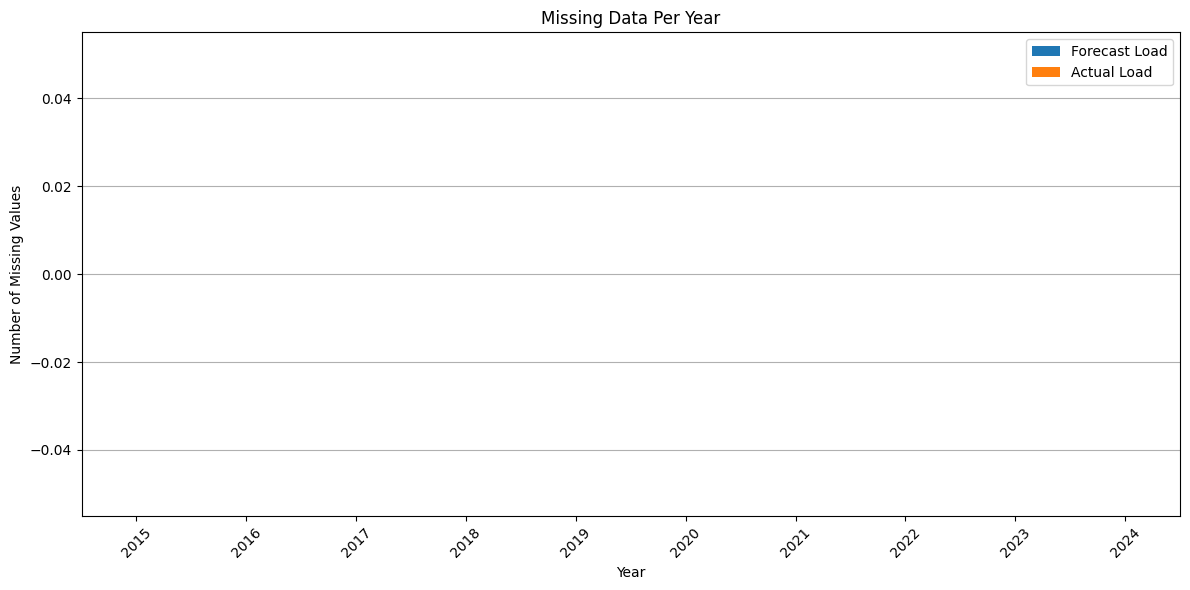

=== Missing Values by Year ===
       Forecast Load  Actual Load  Timestamp  Year
2015               0            0        NaN   NaN
2016               0            0        NaN   NaN
2017               0            0        NaN   NaN
2018               0            0        NaN   NaN
2019               0            0        NaN   NaN
2020               0            0        NaN   NaN
2021               0            0        NaN   NaN
2022               0            0        NaN   NaN
2023               0            0        NaN   NaN
2024               0            0        NaN   NaN
Total              0            0        0.0   0.0

=== Detailed Missing Values with Timestamps ===
Empty DataFrame
Columns: [Year, Timestamp, Column]
Index: []


In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


def smart_fill_hourly_by_pattern(data, max_gap_hours=6):
    """
    Interpolates short gaps using cubic.
    Fills longer gaps hour-by-hour using average of same hour/weekday from previous weeks.
    """
    from datetime import timedelta

    df = data.copy()
    df = df.sort_values('Timestamp').reset_index(drop=True)

    # Add helper columns
    df['Weekday'] = df['Timestamp'].dt.weekday  # Monday=0
    df['Hour'] = df['Timestamp'].dt.hour

    # Step 1: Interpolate short gaps with cubic
    for col in ['Forecast Load', 'Actual Load']:
        df[col] = df[col].interpolate(method='cubic', limit_area='inside', limit_direction='both')

    # Step 2: Fill longer gaps hour-by-hour from past weekly patterns
    for col in ['Forecast Load', 'Actual Load']:
        missing_mask = df[col].isna()

        for idx in df[missing_mask].index:
            ts = df.loc[idx, 'Timestamp']
            weekday = df.loc[idx, 'Weekday']
            hour = df.loc[idx, 'Hour']

            # Look back up to 8 weeks, same weekday & hour
            past_window = ts - pd.to_timedelta(np.arange(7, 8 * 7 + 1, 7), unit='D')
            past_values = []

            for past_date in past_window:
                candidate_time = past_date.replace(hour=hour, minute=0)
                match = df[df['Timestamp'] == candidate_time]
                if not match.empty and pd.notna(match[col].values[0]):
                    past_values.append(match[col].values[0])

            # Fill with mean of past values
            if past_values:
                df.loc[idx, col] = np.mean(past_values)

    # Drop helper columns
    return df.drop(columns=['Weekday', 'Hour'])


# Ensure Timestamp is datetime and sorted
all_data['Timestamp'] = pd.to_datetime(all_data['Timestamp'])
all_data = all_data.sort_values('Timestamp').reset_index(drop=True)

# Apply the smart interpolation strategy
all_data = smart_fill_hourly_by_pattern(all_data)

# --- Missing Data Analysis ---
# Group by year and count missing values
missing_by_year = all_data.groupby(all_data['Timestamp'].dt.year)[['Forecast Load', 'Actual Load']].apply(lambda x: x.isnull().sum())
missing_by_year = missing_by_year.dropna()

# Plot missing data per year
plt.figure(figsize=(12, 6))
missing_by_year.plot(kind='bar', stacked=False, figsize=(12, 6))
plt.title("Missing Data Per Year")
plt.ylabel("Number of Missing Values")
plt.xlabel("Year")
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Add total row
total_missing = all_data.isnull().sum()
total_missing.name = 'Total'
missing_by_year = pd.concat([missing_by_year, total_missing.to_frame().T])

# Display missing summary
print("=== Missing Values by Year ===")
print(missing_by_year)

# Show detailed list of each missing value
print("\n=== Detailed Missing Values with Timestamps ===")
melted = all_data[['Timestamp', 'Forecast Load', 'Actual Load']].melt(id_vars='Timestamp',
                                                                      var_name='Column',
                                                                      value_name='Value')
missing_details = melted[melted['Value'].isnull()].copy()
missing_details['Year'] = missing_details['Timestamp'].dt.year
print(missing_details[['Year', 'Timestamp', 'Column']])

### Dahiyane Plot

In [9]:
import plotly.graph_objects as go
import ipywidgets as widgets
from IPython.display import display


# Define aggregation options
aggregation_options = {
    "Raw Data (Original)": "T",  # Minute-level
    "Hourly": "H",
    "Daily": "D",
    "Weekly": "W",
    "Monthly": "M",
    "Yearly": "Y"
}

# Create dropdown widget
aggregation_selector = widgets.Dropdown(
    options=aggregation_options,
    value="H",  # Default to hourly
    description="Aggregation Level:",
    style={'description_width': 'initial'}
)

# Function to plot interactive data
def plot_interactive_plotly(aggregation):
    # Resample data based on selected aggregation level
    resampled_data = all_data.set_index('Timestamp').resample(aggregation).mean().reset_index()

    # Create figure
    fig = go.Figure()

    # Add Forecast and Actual Load lines
    fig.add_trace(go.Scatter(
        x=resampled_data['Timestamp'], y=resampled_data['Forecast Load'],
        mode='lines', name='Day-Ahead Forecast', line=dict(color='blue')
    ))
    
    fig.add_trace(go.Scatter(
        x=resampled_data['Timestamp'], y=resampled_data['Actual Load'],
        mode='lines', name='Actual Load', line=dict(color='orange')
    ))

    # Highlight No-Wind Periods (if both values are NaN)
    no_wind_periods = resampled_data[(resampled_data['Forecast Load'].isna()) & (resampled_data['Actual Load'].isna())]

    fig.add_trace(go.Scatter(
        x=no_wind_periods['Timestamp'], y=[None] * len(no_wind_periods),
        mode='markers', name='No Wind Periods', marker=dict(color='red', symbol='x')
    ))

    # Update layout
    fig.update_layout(
        title=f'Day-Ahead Forecast vs Actual Load ({aggregation} Aggregation)',
        xaxis_title='Time',
        yaxis_title='Load (MW)',
        legend=dict(orientation="h"),
        template='plotly_white'
    )

    fig.show()

# Display interactive widget
display(widgets.interactive(plot_interactive_plotly, aggregation=aggregation_selector))


interactive(children=(Dropdown(description='Aggregation Level:', index=1, options={'Raw Data (Original)': 'T',…

### Anomalies

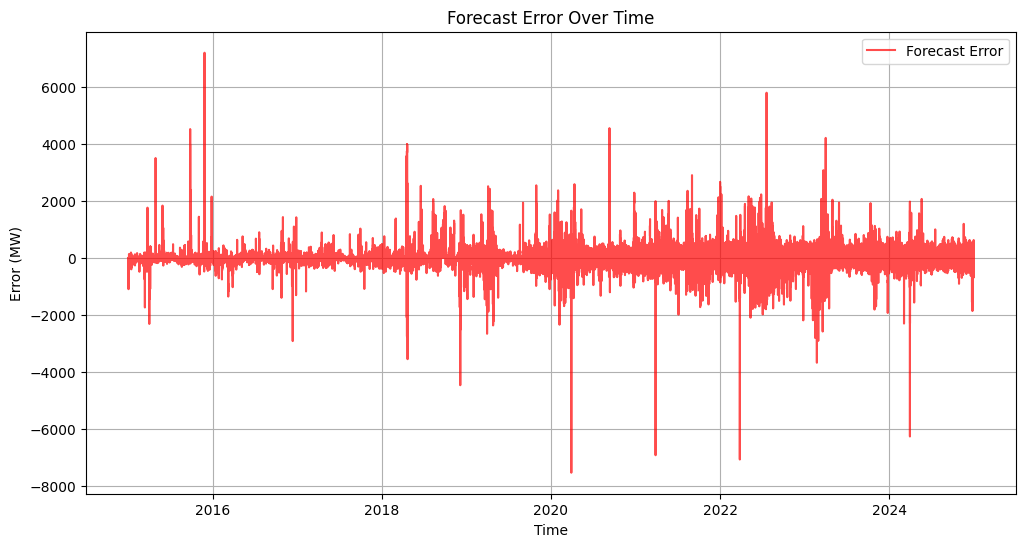

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(all_data['Timestamp'], all_data['Actual Load'] - all_data['Forecast Load'], 
         label='Forecast Error', alpha=0.7, color='red')

plt.xlabel('Time')
plt.ylabel('Error (MW)')
plt.title('Forecast Error Over Time')
plt.legend()
plt.grid()
plt.show()


### Monthly average with group by structure

In [11]:
# Ensure 'Timestamp' is in datetime format (if not already)
all_data['Timestamp'] = pd.to_datetime(all_data['Timestamp'], errors='coerce')

# Extract 'Year' and 'Month' from 'Timestamp'
all_data['Year'] = all_data['Timestamp'].dt.year
all_data['Month'] = all_data['Timestamp'].dt.month

# Group by 'Year' and 'Month' and calculate averages
monthly_avg = all_data.groupby(['Year', 'Month'], as_index=True)[['Forecast Load', 'Actual Load']].mean()

# Display the result
print(monthly_avg)



            Forecast Load   Actual Load
Year Month                             
2015 1       18279.598118  18265.288978
     2       18032.017857  18023.107143
     3       16557.501141  16516.821073
     4       14570.009722  14490.023611
     5       13318.690860  13331.307796
...                   ...           ...
2024 8       12381.735215  12449.002688
     9       13258.136111  13290.179167
     10      15245.664430  15258.950336
     11      17546.643056  17564.827778
     12      18502.290323  18469.852151

[120 rows x 2 columns]


## Next Steps

**Completed:**
 Data Cleaning
 Data Exploration
 Basic Visualization

**To Do Next:**
 Feature Engineering (Rolling Averages, Lag Features)
 Outlier Detection & Handling
 Correlation Analysis
 Seasonality & Trend Analysis
 Data Imbalance Check


## Feature Engineering

### Why is Feature Engineering Important?
To improve forecasting accuracy, we create new time-dependent features such as:
- **Lag Features:** Previous values (e.g., `t-1`, `t-24`) to capture trends.
- **Rolling Averages:** Smooth short-term fluctuations.

### Steps:
1. Compute lag features.
2. Calculate rolling averages.
3. Add day-of-week and month indicators.


               Timestamp  Forecast Load  Actual Load  Year  Month  Day  Hour  \
8640 2015-12-26 23:00:00        14920.0      17065.0  2015     12   26    23   
8641 2015-12-27 00:00:00        16696.0      16695.0  2015     12   27     0   
8642 2015-12-27 01:00:00        16494.0      16494.0  2015     12   27     1   
8643 2015-12-27 02:00:00        16412.0      16411.0  2015     12   27     2   
8644 2015-12-27 03:00:00        16369.0      16369.0  2015     12   27     3   

      Weekday  Is_Weekend  Lag_1H_Forecast  ...  Rolling_6H_Actual  \
8640        5           1          17328.0  ...       17795.666667   
8641        6           1          14920.0  ...       17522.166667   
8642        6           1          16696.0  ...       17235.500000   
8643        6           1          16494.0  ...       16952.333333   
8644        6           1          16412.0  ...       16726.833333   

      Rolling_24H_Forecast  Rolling_24H_Actual  Rolling_168H_Forecast  \
8640          16621.00000

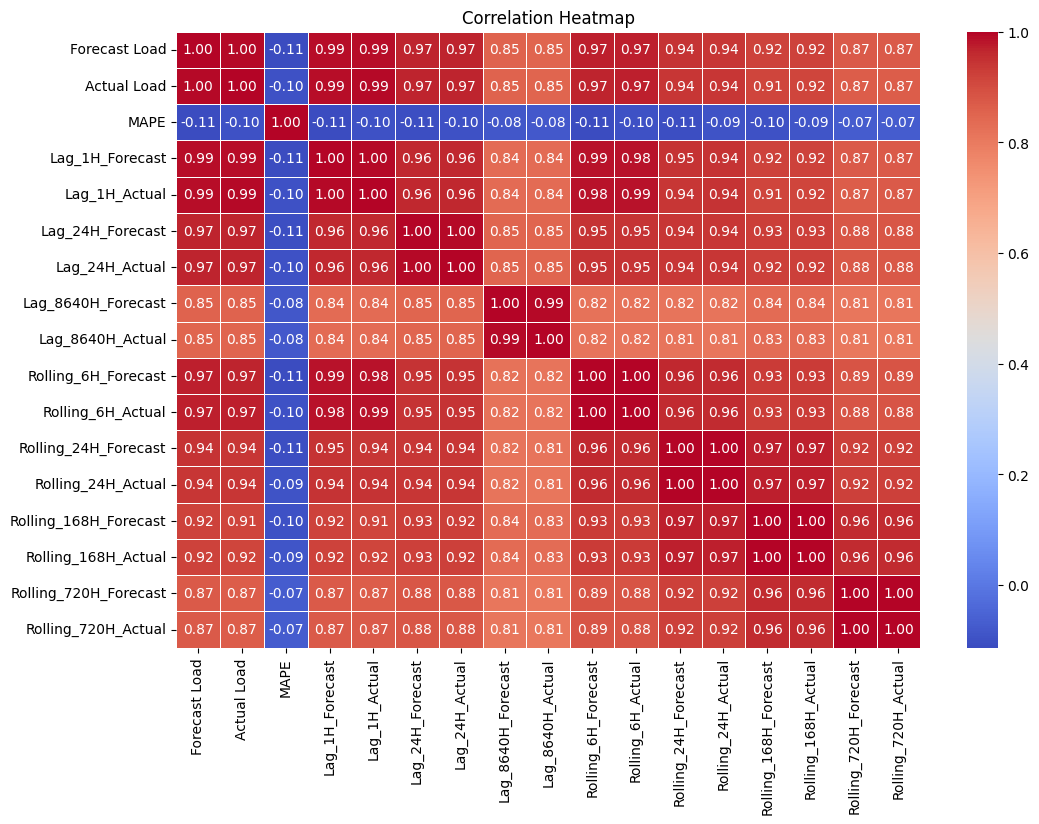

In [12]:
# Convert 'Timestamp' to datetime
all_data['Timestamp'] = pd.to_datetime(all_data['Timestamp'], errors='coerce')

# Extracting additional time-based features
all_data.loc[:, 'Year'] = all_data['Timestamp'].dt.year
all_data.loc[:, 'Month'] = all_data['Timestamp'].dt.month
all_data.loc[:, 'Day'] = all_data['Timestamp'].dt.day
all_data.loc[:, 'Hour'] = all_data['Timestamp'].dt.hour
all_data.loc[:, 'Weekday'] = all_data['Timestamp'].dt.weekday  # Monday=0, Sunday=6
all_data.loc[:, 'Is_Weekend'] = all_data['Weekday'].isin([5, 6]).astype(int)

# Creating lag features
    # One hour lag
all_data.loc[:, 'Lag_1H_Forecast'] = all_data['Forecast Load'].shift(1)
all_data.loc[:, 'Lag_1H_Actual'] = all_data['Actual Load'].shift(1)
    # One Day lag
all_data.loc[:, 'Lag_24H_Forecast'] = all_data['Forecast Load'].shift(24)
all_data.loc[:, 'Lag_24H_Actual'] = all_data['Actual Load'].shift(24)
    # One Year lag
all_data.loc[:, 'Lag_8640H_Forecast'] = all_data['Forecast Load'].shift(8640)
all_data.loc[:, 'Lag_8640H_Actual'] = all_data['Actual Load'].shift(8640)


# Rolling mean features
    # Six hour window
all_data.loc[:, 'Rolling_6H_Forecast'] = all_data['Forecast Load'].rolling(window=6, min_periods=1).mean()
all_data.loc[:, 'Rolling_6H_Actual'] = all_data['Actual Load'].rolling(window=6, min_periods=1).mean()
    # One day window
all_data.loc[:, 'Rolling_24H_Forecast'] = all_data['Forecast Load'].rolling(window=24, min_periods=1).mean()
all_data.loc[:, 'Rolling_24H_Actual'] = all_data['Actual Load'].rolling(window=24, min_periods=1).mean()
    # One week window
all_data.loc[:, 'Rolling_168H_Forecast'] = all_data['Forecast Load'].rolling(window=168, min_periods=1).mean()
all_data.loc[:, 'Rolling_168H_Actual'] = all_data['Actual Load'].rolling(window=168, min_periods=1).mean()
    # One month window
all_data.loc[:, 'Rolling_720H_Forecast'] = all_data['Forecast Load'].rolling(window=720, min_periods=1).mean()
all_data.loc[:, 'Rolling_720H_Actual'] = all_data['Actual Load'].rolling(window=720, min_periods=1).mean()

"""    # One year window
all_data.loc[:, 'Rolling_8640H_Forecast'] = all_data['Forecast Load'].rolling(window=8640, min_periods=1).mean()
all_data.loc[:, 'Rolling_8640H_Actual'] = all_data['Actual Load'].rolling(window=8640, min_periods=1).mean()
"""

# Difference between forecast and actual load
all_data.loc[:, 'Load_Error'] = all_data['Forecast Load'] - all_data['Actual Load']
all_data.loc[:, 'Absolute_Error'] = abs(all_data['Load_Error'])

# Percentage error (MAPE) with a safeguard for division by zero
all_data.loc[:, 'MAPE'] = (all_data['Absolute_Error'] / (all_data['Actual Load'] + 1e-6)) * 100

# Handling missing values that may arise due to lag features
all_data = all_data.dropna()

# Display processed data sample
print(all_data.head())


# Select relevant numerical columns only (excluding non-existent or highly NaN features)
columns_to_include = [
    'Forecast Load', 'Actual Load', 'MAPE', 
    'Lag_1H_Forecast', 'Lag_1H_Actual', 'Lag_24H_Forecast', 'Lag_24H_Actual', 'Lag_8640H_Forecast', 'Lag_8640H_Actual',
    'Rolling_6H_Forecast', 'Rolling_6H_Actual', 'Rolling_24H_Forecast', 'Rolling_24H_Actual', 
    'Rolling_168H_Forecast', 'Rolling_168H_Actual', 'Rolling_720H_Forecast', 'Rolling_720H_Actual'
]

# Ensure only existing columns are selected (avoiding errors)
columns_to_include = [col for col in columns_to_include if col in all_data.columns]

# Compute correlation matrix
corr_matrix = all_data[columns_to_include].corr()

# Create heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()


## Outlier Detection

### Why is it Important?
Outliers can distort predictions and must be identified.

### Steps:
1. **Visualize using Box Plots**
2. **Compute Z-Scores or IQR**
3. **Decide: Remove or Transform?**


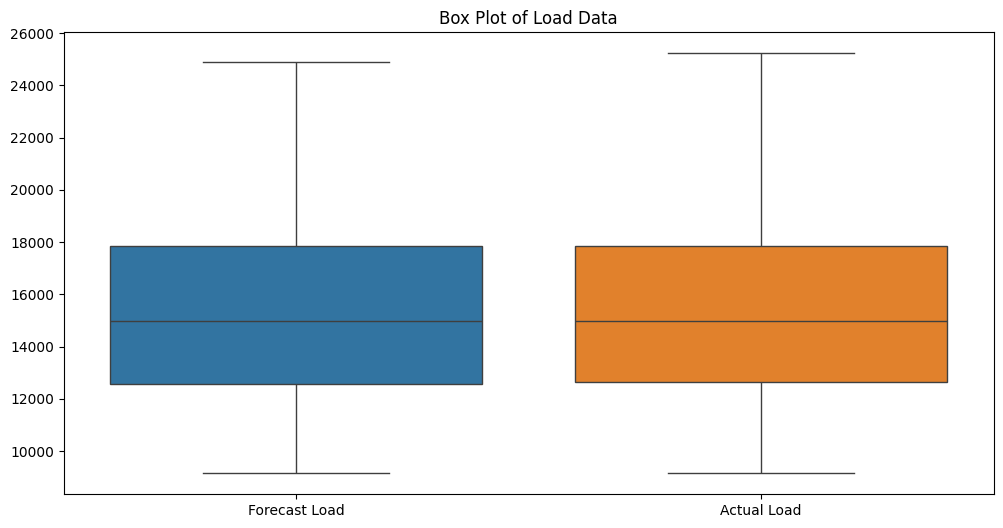

In [13]:
### *Outlier Detection Code Below:*

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.boxplot(data=all_data[['Forecast Load', 'Actual Load']])
plt.title('Box Plot of Load Data')
plt.show()


## Correlation Analysis

### Why is it Important?
Identifying relationships between variables helps remove redundancy.

### Steps:
1. Compute correlation matrix.
2. Visualize with a heatmap.
3. Identify highly correlated features.


In [14]:
### *Correlation Analysis Code Below:*

from scipy.stats import zscore

all_data['Forecast_Z'] = zscore(all_data['Forecast Load'])
all_data['Actual_Z'] = zscore(all_data['Actual Load'])

# Show rows where the absolute Z-score is greater than 3 (potential outliers)
outliers = all_data[(all_data['Forecast_Z'].abs() > 3) | (all_data['Actual_Z'].abs() > 3)]
print(outliers)


Q1 = all_data[['Forecast Load', 'Actual Load']].quantile(0.25)
Q3 = all_data[['Forecast Load', 'Actual Load']].quantile(0.75)
IQR = Q3 - Q1

outliers_iqr = all_data[((all_data[['Forecast Load', 'Actual Load']] < (Q1 - 1.5 * IQR)) | 
                         (all_data[['Forecast Load', 'Actual Load']] > (Q3 + 1.5 * IQR))).any(axis=1)]

print(outliers_iqr)


                Timestamp  Forecast Load  Actual Load  Year  Month  Day  Hour  \
53438 2021-02-04 08:00:00        24901.0      25146.0  2021      2    4     8   
53462 2021-02-05 08:00:00        24766.0      24991.0  2021      2    5     8   
53463 2021-02-05 09:00:00        24706.0      25047.0  2021      2    5     9   
53606 2021-02-11 08:00:00        24825.0      24977.0  2021      2   11     8   
53631 2021-02-12 09:00:00        24816.0      25230.0  2021      2   12     9   

       Weekday  Is_Weekend  Lag_1H_Forecast  ...  Rolling_24H_Actual  \
53438        3           0          24690.0  ...        22931.916667   
53462        4           0          24494.0  ...        23278.333333   
53463        4           0          24766.0  ...        23281.833333   
53606        3           0          24267.0  ...        23050.708333   
53631        4           0          24654.0  ...        23071.791667   

       Rolling_168H_Forecast  Rolling_168H_Actual  Rolling_720H_Forecast  \
5343

## Time-Series Decomposition

### Why?
- Helps visualize long-term trends.
- Identifies seasonal patterns.

### Steps:
1. Use `seasonal_decompose()`.
2. Plot components (Trend, Seasonality, Residuals).
3. Decide if detrending is needed.


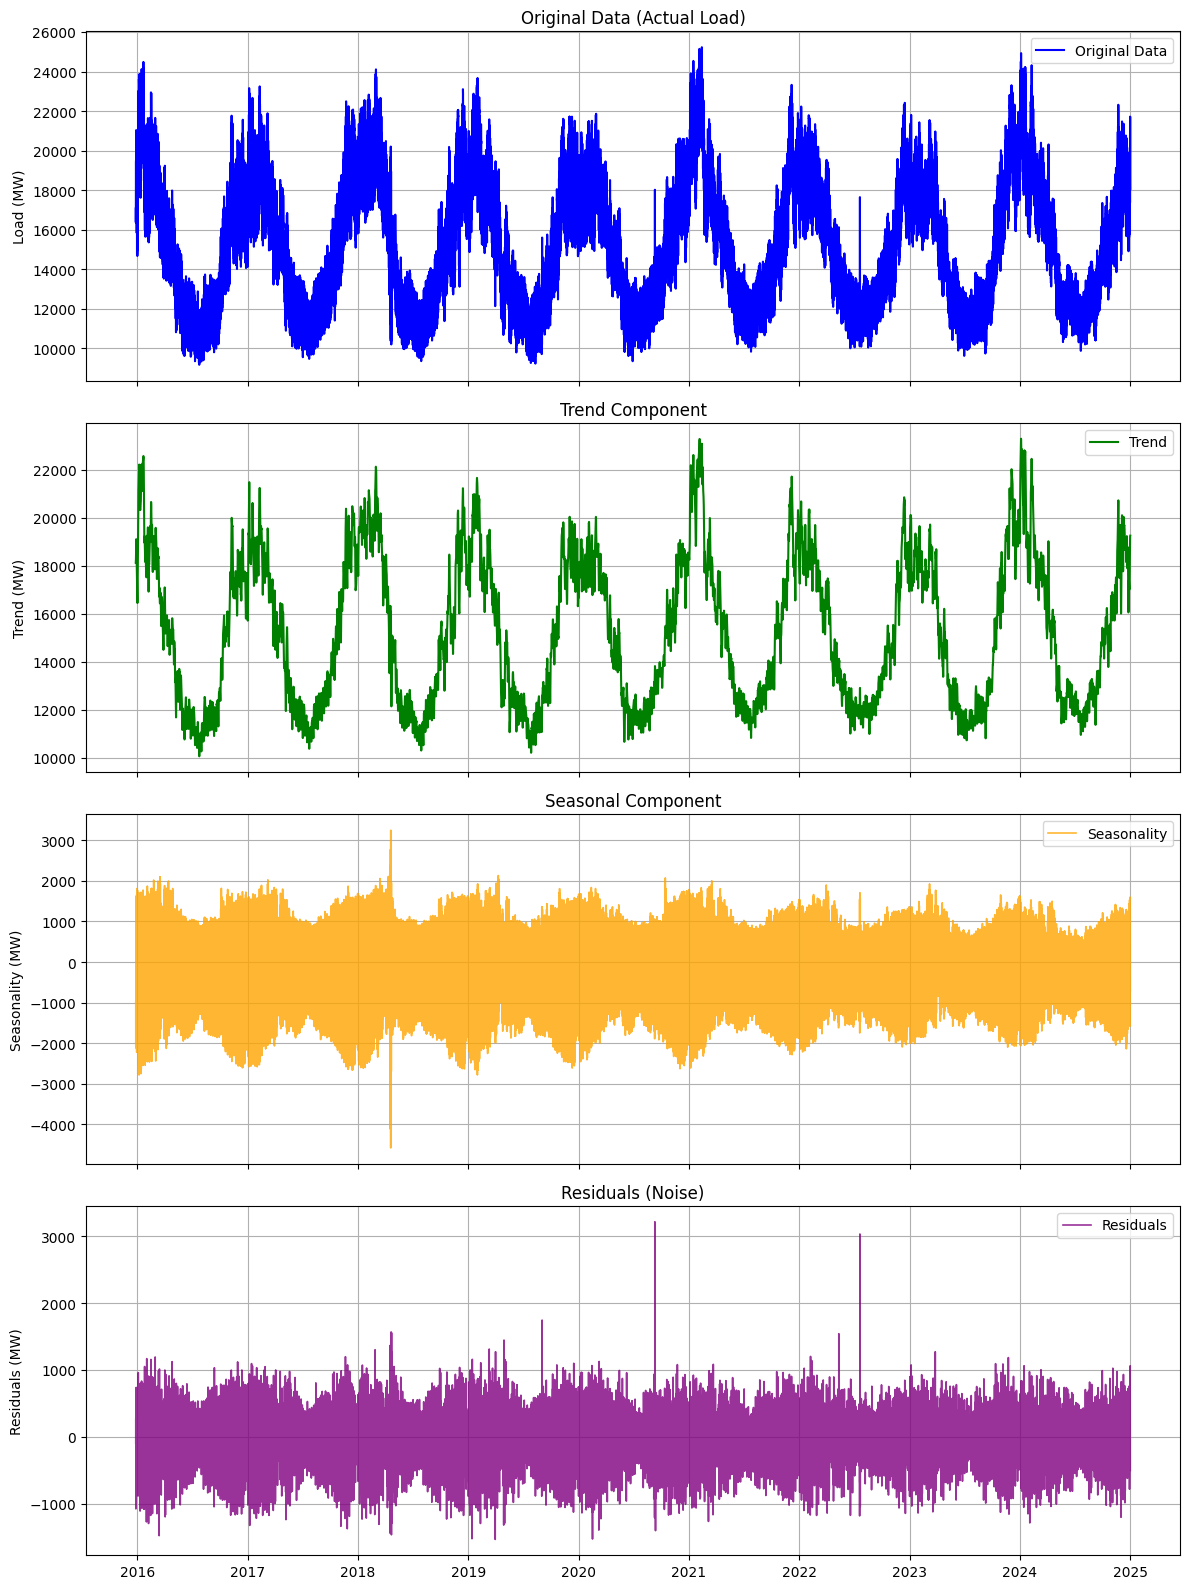

In [15]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL

# Ensure the Timestamp is set as the index and sorted
ts = all_data.set_index('Timestamp').sort_index()

# Choose the time series to decompose (drop missing values if necessary)
series = ts['Actual Load'].dropna()

# Specify the period for the seasonal component.
# For hourly data with daily seasonality, period=24; adjust as needed.
stl = STL(series, period=24)
result = stl.fit()

# Plot each component separately for better clarity
fig, axes = plt.subplots(4, 1, figsize=(12, 16), sharex=True)

# Original Data
axes[0].plot(series, label='Original Data', color='blue', linewidth=1.5)
axes[0].set_title('Original Data (Actual Load)')
axes[0].set_ylabel('Load (MW)')
axes[0].legend()
axes[0].grid(True)

# Trend Component
axes[1].plot(result.trend, label='Trend', color='green', linewidth=1.5)
axes[1].set_title('Trend Component')
axes[1].set_ylabel('Trend (MW)')
axes[1].legend()
axes[1].grid(True)

# Seasonal Component
axes[2].plot(result.seasonal, label='Seasonality', color='orange', linewidth=1.2, alpha=0.8)
axes[2].set_title('Seasonal Component')
axes[2].set_ylabel('Seasonality (MW)')
axes[2].legend()
axes[2].grid(True)

# Residuals (Noise)
axes[3].plot(result.resid, label='Residuals', color='purple', linewidth=1.2, alpha=0.8)
axes[3].set_title('Residuals (Noise)')
axes[3].set_ylabel('Residuals (MW)')
axes[3].legend()
axes[3].grid(True)

plt.tight_layout()
plt.show()


## Methodology

ESN Hyperparam set 1/20: {'input_scaling': np.float64(1.0618101782710436), 'lr': np.float64(0.4802857225639665), 'sr': np.float64(1.385595153449124), 'units': 1244}
 -> Found in cache, skipping training.
 -> CV MAPE: 0.918%
ESN Hyperparam set 2/20: {'input_scaling': np.float64(0.7340279606636548), 'lr': np.float64(0.16239780813448107), 'sr': np.float64(0.8464668897345596), 'units': 287}
 -> Found in cache, skipping training.
 -> CV MAPE: 1.282%
ESN Hyperparam set 3/20: {'input_scaling': np.float64(1.0005629167085328), 'lr': np.float64(0.1571467271687763), 'sr': np.float64(1.3207107783590823), 'units': 969}
 -> Found in cache, skipping training.
 -> CV MAPE: 1.853%
ESN Hyperparam set 4/20: {'input_scaling': np.float64(1.582998158400237), 'lr': np.float64(0.4754210836063001), 'sr': np.float64(0.8006230126728116), 'units': 1155}
 -> Found in cache, skipping training.
 -> CV MAPE: 0.879%
ESN Hyperparam set 5/20: {'input_scaling': np.float64(0.7751067647801507), 'lr': np.float64(0.221696897

Running Model-0: 63214it [00:04, 14485.71it/s], ?it/s]
Running Model-0: 100%|██████████| 1/1 [00:04<00:00,  4.56s/it]


Fitting node Ridge-0...


Running Model-0: 15804it [00:01, 15239.00it/s]        



FINAL ESN on Test => MAE=140.86, RMSE=185.02, MAPE=0.94%, trainTime=4.70s


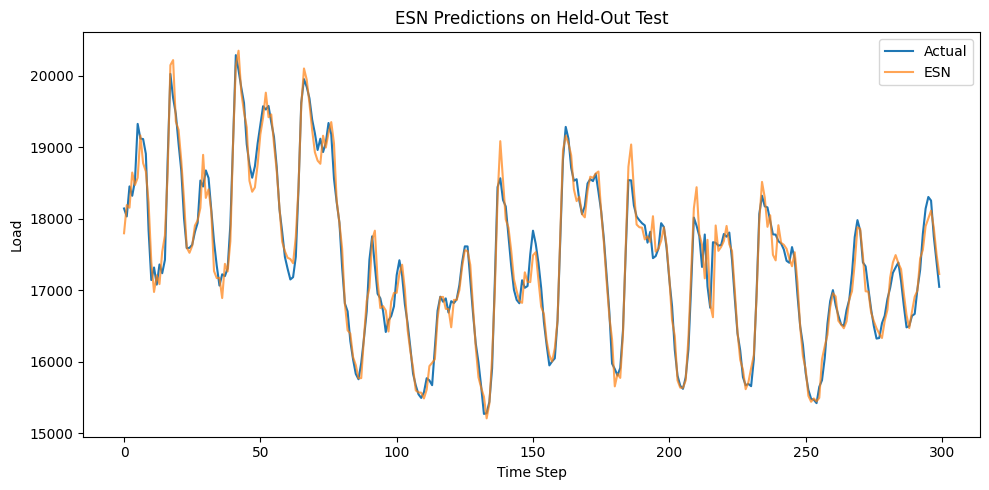

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import joblib
import os

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, ParameterSampler
from reservoirpy.nodes import Reservoir, Ridge
from scipy.stats import uniform, randint

##############################################################################
# 1) DATA LOADING & PREP
##############################################################################

# Suppose `all_data` has: [Timestamp, Actual Load, ...] + optional Forecast Load
df = all_data.dropna().copy()
df.sort_values('Timestamp', inplace=True)

# Example: Extended time-based, lags, etc.
df['Hour'] = df['Timestamp'].dt.hour
df['Weekday'] = df['Timestamp'].dt.weekday
df['Month'] = df['Timestamp'].dt.month
df['Lag_1H'] = df['Actual Load'].shift(1)
df['Lag_24H'] = df['Actual Load'].shift(24)
df.dropna(inplace=True)

# Let’s define a simple single-step target for now


features = [
    'Hour', 'Weekday', 'Month',
    'Lag_1H', 'Lag_24H'
]
X = df[features].values
y = df['Actual Load'].values.reshape(-1,1)

# Single final test holdout
split_idx = int(0.8 * len(X))
df_train = df.iloc[:split_idx]
df_test  = df.iloc[split_idx:]

X_train_all = df_train[features].values
y_train_all = df_train['Actual Load'].values.reshape(-1,1)
X_test_final = df_test[features].values
y_test_final = df_test['Actual Load'].values.reshape(-1,1)

# Scale
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_train_all_scaled = scaler_X.fit_transform(X_train_all)
y_train_all_scaled = scaler_y.fit_transform(y_train_all)

X_test_final_scaled = scaler_X.transform(X_test_final)
# y_test_final_scaled = scaler_y.transform(y_test_final) # if needed


##############################################################################
# 3) CROSS-VALIDATION + RANDOM SEARCH for ESN
##############################################################################

n_splits = 3
tscv = TimeSeriesSplit(n_splits=n_splits)

param_dist = {
    'units': randint(200, 1500),
    'sr': uniform(0.8, 0.8),          # [0.8,1.6]
    'lr': uniform(0.1, 0.4),         # [0.1,0.5]
    'input_scaling': uniform(0.5,1.5)# [0.5,2.0]
}
n_iter = 20  # Try 20 random combos
param_list = list(ParameterSampler(param_dist, n_iter=n_iter, random_state=42))

# We'll store the crossval results in a joblib cache
cache_file = 'esn_cv_results.pkl'
if os.path.exists(cache_file):
    # Load existing cache
    with open(cache_file, 'rb') as f:
        cv_cache = joblib.load(f)
else:
    cv_cache = {}

def train_esn_on_fold(X_train_fold, y_train_fold, X_val_fold, y_val_fold, params):
    """
    Train an ESN with specified hyperparams on a single fold.
    Return MAPE or some chosen error.
    """
    # Scale fold
    scalerX_fold = MinMaxScaler()
    scalerY_fold = MinMaxScaler()
    X_train_fold_scaled = scalerX_fold.fit_transform(X_train_fold)
    y_train_fold_scaled = scalerY_fold.fit_transform(y_train_fold)
    X_val_fold_scaled   = scalerX_fold.transform(X_val_fold)
    # y_val_fold_scaled   = scalerY_fold.transform(y_val_fold) # only if needed for internal metrics

    # Build ESN
    reservoir = Reservoir(
        units=params['units'],
        sr=params['sr'],
        lr=params['lr'],
        input_scaling=params['input_scaling'],
        seed=42
    )
    readout = Ridge(ridge=1e-6)
    esn_model = reservoir >> readout

    esn_model.fit(X_train_fold_scaled, y_train_fold_scaled)
    y_pred_fold_scaled = esn_model.run(X_val_fold_scaled)
    y_pred_fold = scalerY_fold.inverse_transform(y_pred_fold_scaled)

    mae = mean_absolute_error(y_val_fold, y_pred_fold)
    rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred_fold))
    mape = np.mean(np.abs((y_val_fold - y_pred_fold)/y_val_fold)) * 100

    return mae, rmse, mape

cv_results = []
best_mape = float('inf')
best_params = None

for idx, params in enumerate(param_list):
    print(f"ESN Hyperparam set {idx+1}/{len(param_list)}: {params}")

    # We'll create a cache key
    cache_key = tuple(sorted(params.items()))  # So we can store by param set

    if cache_key in cv_cache:
        print(" -> Found in cache, skipping training.")
        mean_mape = cv_cache[cache_key]['mean_mape']
    else:
        # Perform cross val over n_splits
        fold_mapes = []
        for fold_idx, (train_idx, val_idx) in enumerate(tscv.split(X_train_all_scaled)):
            # Build folds
            X_train_fold = X_train_all[train_idx]
            y_train_fold = y_train_all[train_idx].reshape(-1,1)
            X_val_fold   = X_train_all[val_idx]
            y_val_fold   = y_train_all[val_idx].reshape(-1,1)

            # Train on this fold
            mae_, rmse_, mape_ = train_esn_on_fold(X_train_fold, y_train_fold, X_val_fold, y_val_fold, params)
            fold_mapes.append(mape_)

        mean_mape = np.mean(fold_mapes)
        # Store in cache
        cv_cache[cache_key] = {'mean_mape': mean_mape, 'fold_mapes': fold_mapes}

    if mean_mape < best_mape:
        best_mape = mean_mape
        best_params = params

    print(f" -> CV MAPE: {mean_mape:.3f}%")

    # Gather results
    cv_results.append({
        'params': params,
        'mean_mape': mean_mape
    })

# Save the updated cache
with open(cache_file, 'wb') as f:
    joblib.dump(cv_cache, f)

cv_results_df = pd.DataFrame(cv_results).sort_values('mean_mape')
print("\nCV RESULTS:\n", cv_results_df.head(10))
print(f"\nBEST PARAMS: {best_params}, MAPE={best_mape:.3f}%")

##############################################################################
# 4) RETRAIN BEST ESN on Full Training Data + Evaluate on Held-out
##############################################################################
# Scale full training
scalerX_full = MinMaxScaler()
scalerY_full = MinMaxScaler()

X_train_all_scaled = scalerX_full.fit_transform(X_train_all)
y_train_all_scaled = scalerY_full.fit_transform(y_train_all)

X_test_final_scaled = scalerX_full.transform(X_test_final)

# Build ESN with best_params
reservoir = Reservoir(
    units=int(best_params['units']),
    sr=float(best_params['sr']),
    lr=float(best_params['lr']),
    input_scaling=float(best_params['input_scaling']),
    seed=42
)
readout = Ridge(ridge=1e-6)
best_esn = reservoir >> readout

start_time = time.time()
best_esn.fit(X_train_all_scaled, y_train_all_scaled)
train_time = time.time() - start_time

y_pred_scaled = best_esn.run(X_test_final_scaled)
y_pred_final = scalerY_full.inverse_transform(y_pred_scaled)

mae_final = mean_absolute_error(y_test_final, y_pred_final)
rmse_final = np.sqrt(mean_squared_error(y_test_final, y_pred_final))
mape_final = np.mean(np.abs((y_test_final - y_pred_final)/y_test_final)) * 100

print(f"\nFINAL ESN on Test => MAE={mae_final:.2f}, RMSE={rmse_final:.2f}, MAPE={mape_final:.2f}%, trainTime={train_time:.2f}s")

##############################################################################
# 5) PLOT PREDICTIONS
##############################################################################
max_plot = 300
plt.figure(figsize=(10,5))
plt.plot(y_test_final[:max_plot], label='Actual', linewidth=1.5)
plt.plot(y_pred_final[:max_plot], label='ESN', alpha=0.7)
plt.title('ESN Predictions on Held-Out Test')
plt.xlabel('Time Step')
plt.ylabel('Load')
plt.legend()
plt.tight_layout()
plt.savefig('final_esn_predictions.png', dpi=300)
plt.show()


interpreting the final outcome:

Cross-Validation MAPE ~0.87%

With TimeSeriesSplit, your ESN showed an average MAPE of 0.87% on the training folds.

That’s already quite low for energy load forecasting.

Final Test MAPE ~0.94%

On the held-out test set, the error is 0.94% — very close to the CV estimate.

This indicates your model is not overfitting; it generalizes well beyond the training folds.

Training Time ~5 seconds

ESN still trains very fast compared to many other time-series methods (e.g., large GBMs, deep RNNs).

Plot shows a close fit between actual load and ESN predictions.

Occasional small deviations but overall captures peaks and valleys well.

Why This Is Encouraging
Cross-val vs. Final: Only a ~0.07% difference (0.87 → 0.94 MAPE) suggests a stable model.

Speed and Accuracy: Balances near-1% error with a few seconds of training time — an excellent trade-off for operational forecasting.

Potential Refinements
Extend Cross-Validation

Increase n_splits from 3 to 5 or 7 for an even more robust measure.

Expand n_iter in random search to 30 or 50 to explore more hyperparam combos.

More Feature Engineering

Add additional lags (6h, 12h, 168h), rolling means, or weather data.

ESN can handle many features without the heavy training cost of deep networks.


Bottom Line: A final test MAPE under 1% in energy forecasting is typically quite good. Your cross-validation approach confirms the model’s stability, and the quick training time cements ESN as a strong choice for real-world time-series prediction.


--- LSTM HYPERPARAM SEARCH (Parallel) ---


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:    2.4s remaining:    4.0s
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:    2.4s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    2.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s


Params={'hidden_dim': 32, 'num_layers': 1, 'learning_rate': 0.001, 'epochs': 10, 'batch_size': 64}, Seeds avg => MAPE=1.455%, MAE=219.40, RMSE=294.76, R2=0.9916
Params={'hidden_dim': 32, 'num_layers': 1, 'learning_rate': 0.0003, 'epochs': 10, 'batch_size': 64}, Seeds avg => MAPE=1.480%, MAE=223.48, RMSE=301.66, R2=0.9912
Params={'hidden_dim': 32, 'num_layers': 2, 'learning_rate': 0.001, 'epochs': 10, 'batch_size': 64}, Seeds avg => MAPE=1.593%, MAE=242.23, RMSE=323.72, R2=0.9897
Params={'hidden_dim': 32, 'num_layers': 2, 'learning_rate': 0.0003, 'epochs': 10, 'batch_size': 64}, Seeds avg => MAPE=1.459%, MAE=221.19, RMSE=300.27, R2=0.9913
Params={'hidden_dim': 64, 'num_layers': 1, 'learning_rate': 0.001, 'epochs': 10, 'batch_size': 64}, Seeds avg => MAPE=1.497%, MAE=227.02, RMSE=304.98, R2=0.9910
Params={'hidden_dim': 64, 'num_layers': 1, 'learning_rate': 0.0003, 'epochs': 10, 'batch_size': 64}, Seeds avg => MAPE=1.457%, MAE=220.60, RMSE=300.85, R2=0.9912
Params={'hidden_dim': 64, 'num_

[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.7s finished


Params={'hidden_dim': 32, 'learning_rate': 0.001, 'epochs': 10, 'batch_size': 64}, Seeds avg => MAPE=1.365%, MAE=206.51, RMSE=269.38, R2=0.9930
Params={'hidden_dim': 32, 'learning_rate': 0.0003, 'epochs': 10, 'batch_size': 64}, Seeds avg => MAPE=1.444%, MAE=218.43, RMSE=293.19, R2=0.9917
Params={'hidden_dim': 64, 'learning_rate': 0.001, 'epochs': 10, 'batch_size': 64}, Seeds avg => MAPE=1.442%, MAE=217.71, RMSE=281.69, R2=0.9923
Params={'hidden_dim': 64, 'learning_rate': 0.0003, 'epochs': 10, 'batch_size': 64}, Seeds avg => MAPE=1.442%, MAE=217.77, RMSE=290.49, R2=0.9918

BEST CNN+LSTM PARAMS: {'hidden_dim': 32, 'learning_rate': 0.001, 'epochs': 10, 'batch_size': 64} => {'mae': np.float64(206.5119737287445), 'rmse': np.float64(269.3846522181586), 'mape': np.float64(1.3650174440287628), 'r2': np.float64(0.9929729587310642)}

--- Retraining FINAL LSTM with best params, repeated seeds ---

--- Retraining FINAL CNN+LSTM with best params, repeated seeds ---

FINAL COMPARISON:
ESN     => MAE

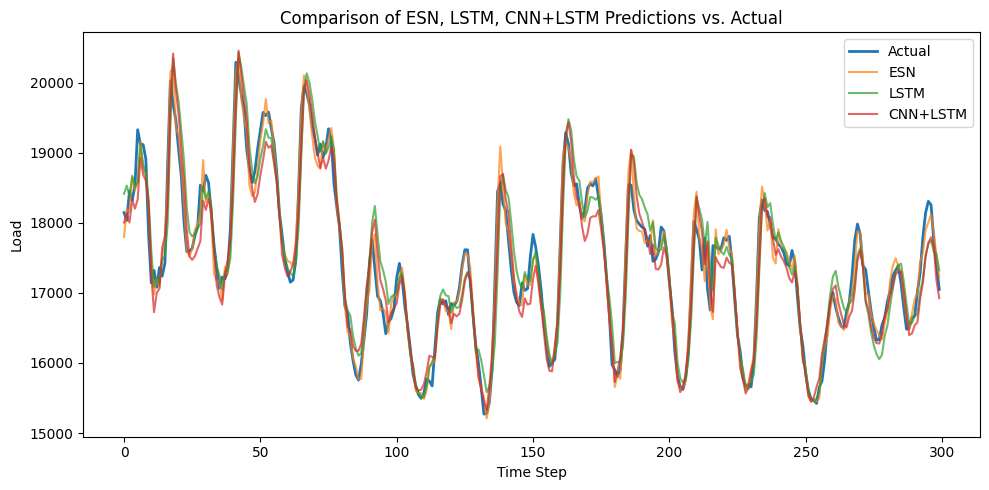

In [17]:
##############################################################################
# 6) EXTENDED LSTM and CNN+LSTM in PyTorch with Joblib Parallel + Caching
##############################################################################
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import r2_score
from scipy.stats import ttest_rel
import numpy as np
import itertools
import random
import copy
import matplotlib.pyplot as plt

from joblib import Parallel, delayed, Memory

# Create a directory for caching (if it doesn't exist, joblib will create it)
memory = Memory(location="./joblib_cache", verbose=1)

# We assume you already have:
# - X_train_all_scaled, y_train_all_scaled -> your scaled training data (numpy)
# - X_test_final_scaled                   -> your scaled test data (numpy)
# - y_test_final                          -> your unscaled test labels for final metrics (numpy)
# - scalerY_full                          -> your fitted MinMaxScaler for 'y'
# - best_esn predictions in y_pred_final  -> your ESN predictions on the test set (numpy)

# --------------------------------------------------------------------
# 6.1) Prepare Data for PyTorch
# --------------------------------------------------------------------
X_train_torch_base = torch.from_numpy(X_train_all_scaled).float()
y_train_torch_base = torch.from_numpy(y_train_all_scaled).float()
X_test_torch = torch.from_numpy(X_test_final_scaled).float()

def reshape_for_lstm(X_torch):
    # e.g. (N, num_features) => (N, 1, num_features)
    return X_torch.unsqueeze(1)

# --------------------------------------------------------------------
# 6.2) Model Classes (LSTMModel, CNNLSTMModel)
# --------------------------------------------------------------------
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=1, output_dim=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        lstm_out, (h_n, c_n) = self.lstm(x)
        last_out = lstm_out[:, -1, :]
        out = self.fc(last_out)
        return out

class CNNLSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, output_dim=1):
        super(CNNLSTMModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_dim, out_channels=32, kernel_size=1)
        self.pool = nn.MaxPool1d(kernel_size=1)
        self.lstm = nn.LSTM(32, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # x shape: (batch_size, seq_len=1, input_dim)
        x = x.transpose(1, 2)  # => (batch, input_dim, seq_len=1)
        x = self.conv1(x)      # => (batch, 32, seq_len=1)
        x = self.pool(x)       # => (batch, 32, seq_len=1)
        x = x.transpose(1, 2)  # => (batch, seq_len=1, 32)
        lstm_out, _ = self.lstm(x)
        last_out = lstm_out[:, -1, :]
        out = self.fc(last_out)
        return out

# --------------------------------------------------------------------
# 6.3) CACHED Helper Function: Train/Eval
# --------------------------------------------------------------------
@memory.cache  # joblib cache decorator
def train_and_evaluate_model(
    model_type='lstm',        # 'lstm' or 'cnn'
    hidden_dim=64,
    num_layers=1,
    learning_rate=1e-3,
    epochs=10,
    batch_size=64,
    seed=42
):
    """
    Trains either LSTM or CNN+LSTM on a single train set,
    returns final predictions on the test set and metrics.
    Caching is applied: if the same (model_type, hidden_dim, num_layers, learning_rate, epochs, batch_size, seed)
    is called again, joblib will skip re-computing and load from cache.
    """

    # Set random seeds for reproducibility
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    # Prepare data
    X_train_torch = reshape_for_lstm(X_train_torch_base)
    y_train_torch = y_train_torch_base

    # DataLoader
    train_dataset = torch.utils.data.TensorDataset(X_train_torch, y_train_torch)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    input_dim = X_train_all_scaled.shape[1]

    # Build model
    if model_type == 'lstm':
        model = LSTMModel(input_dim=input_dim, hidden_dim=hidden_dim, num_layers=num_layers, output_dim=1)
    else:
        model = CNNLSTMModel(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=1)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Train loop
    model.train()
    for epoch_i in range(epochs):
        total_loss = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            if y_batch.dim() == 1:
                y_batch = y_batch.unsqueeze(1)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * X_batch.size(0)
        # epoch_loss = total_loss / len(train_loader.dataset)
        # (Optional print) print(f"[{model_type.upper()}] Epoch {epoch_i+1}/{epochs}, Loss={epoch_loss:.6f}")

    # Evaluate on test
    model.eval()
    with torch.no_grad():
        y_pred_test = model(reshape_for_lstm(X_test_torch))
    y_pred_test_np = y_pred_test.detach().numpy()

    # Inverse transform
    y_pred_unscaled = scalerY_full.inverse_transform(y_pred_test_np)

    # Compute errors
    mae = np.mean(np.abs(y_test_final - y_pred_unscaled))
    rmse = np.sqrt(np.mean((y_test_final - y_pred_unscaled)**2))
    mape = np.mean(np.abs((y_test_final - y_pred_unscaled) / y_test_final)) * 100
    r2 = r2_score(y_test_final, y_pred_unscaled)

    metrics = {
        'mae': mae,
        'rmse': rmse,
        'mape': mape,
        'r2': r2,
        'preds': y_pred_unscaled
    }
    return metrics

# --------------------------------------------------------------------
# 6.4) Minimal Hyperparam Search + Repeated Seeds
#     with joblib Parallel
# --------------------------------------------------------------------
import math

lstm_param_grid = {
    'hidden_dim': [32, 64],
    'num_layers': [1, 2],
    'learning_rate': [1e-3, 3e-4],
    'epochs': [10],
    'batch_size': [64],
}
cnn_param_grid = {
    'hidden_dim': [32, 64],
    'learning_rate': [1e-3, 3e-4],
    'epochs': [10],
    'batch_size': [64],
}

def param_grid_to_list(param_grid):
    keys = list(param_grid.keys())
    combos = []
    for values in itertools.product(*[param_grid[k] for k in keys]):
        combos.append(dict(zip(keys, values)))
    return combos

lstm_params_list = param_grid_to_list(lstm_param_grid)
cnn_params_list = param_grid_to_list(cnn_param_grid)

repetition_seeds = [42, 43, 44]

print("\n--- LSTM HYPERPARAM SEARCH (Parallel) ---")

def run_lstm_config(pset):
    # We'll average metrics over repeated seeds
    mapes, maes, rmses, r2s = [], [], [], []
    for sd in repetition_seeds:
        metrics = train_and_evaluate_model(
            model_type='lstm',
            hidden_dim=pset['hidden_dim'],
            num_layers=pset.get('num_layers', 1),
            learning_rate=pset['learning_rate'],
            epochs=pset['epochs'],
            batch_size=pset['batch_size'],
            seed=sd
        )
        mapes.append(metrics['mape'])
        maes.append(metrics['mae'])
        rmses.append(metrics['rmse'])
        r2s.append(metrics['r2'])
    mean_mape = np.mean(mapes)
    mean_mae  = np.mean(maes)
    mean_rmse = np.mean(rmses)
    mean_r2   = np.mean(r2s)
    return pset, (mean_mape, mean_mae, mean_rmse, mean_r2)

lstm_results = Parallel(n_jobs=-1, verbose=5)(
    delayed(run_lstm_config)(pset) for pset in lstm_params_list
)

best_lstm_mape = float('inf')
best_lstm_params = None
best_lstm_metrics = None

for (pset, (mean_mape, mean_mae, mean_rmse, mean_r2)) in lstm_results:
    print(f"Params={pset}, Seeds avg => MAPE={mean_mape:.3f}%, MAE={mean_mae:.2f}, RMSE={mean_rmse:.2f}, R2={mean_r2:.4f}")
    if mean_mape < best_lstm_mape:
        best_lstm_mape = mean_mape
        best_lstm_params = copy.deepcopy(pset)
        best_lstm_metrics = {
            'mae': mean_mae, 'rmse': mean_rmse, 'mape': mean_mape, 'r2': mean_r2
        }

print("\nBEST LSTM PARAMS:", best_lstm_params, "=>", best_lstm_metrics)

print("\n--- CNN+LSTM HYPERPARAM SEARCH (Parallel) ---")

def run_cnn_config(pset):
    mapes, maes, rmses, r2s = [], [], [], []
    for sd in repetition_seeds:
        metrics = train_and_evaluate_model(
            model_type='cnn',
            hidden_dim=pset['hidden_dim'],
            learning_rate=pset['learning_rate'],
            epochs=pset['epochs'],
            batch_size=pset['batch_size'],
            seed=sd
        )
        mapes.append(metrics['mape'])
        maes.append(metrics['mae'])
        rmses.append(metrics['rmse'])
        r2s.append(metrics['r2'])
    mean_mape = np.mean(mapes)
    mean_mae  = np.mean(maes)
    mean_rmse = np.mean(rmses)
    mean_r2   = np.mean(r2s)
    return pset, (mean_mape, mean_mae, mean_rmse, mean_r2)

cnn_results = Parallel(n_jobs=-1, verbose=5)(
    delayed(run_cnn_config)(pset) for pset in cnn_params_list
)

best_cnn_mape = float('inf')
best_cnn_params = None
best_cnn_metrics = None

for (pset, (mean_mape, mean_mae, mean_rmse, mean_r2)) in cnn_results:
    print(f"Params={pset}, Seeds avg => MAPE={mean_mape:.3f}%, MAE={mean_mae:.2f}, RMSE={mean_rmse:.2f}, R2={mean_r2:.4f}")
    if mean_mape < best_cnn_mape:
        best_cnn_mape = mean_mape
        best_cnn_params = copy.deepcopy(pset)
        best_cnn_metrics = {
            'mae': mean_mae, 'rmse': mean_rmse, 'mape': mean_mape, 'r2': mean_r2
        }

print("\nBEST CNN+LSTM PARAMS:", best_cnn_params, "=>", best_cnn_metrics)

# --------------------------------------------------------------------
# 6.5) Retrain final LSTM & CNN+LSTM + multiple seeds => final preds
# --------------------------------------------------------------------
print("\n--- Retraining FINAL LSTM with best params, repeated seeds ---")
lstm_final_preds_list = []
for sd in repetition_seeds:
    final_metrics = train_and_evaluate_model(
        model_type='lstm',
        hidden_dim=best_lstm_params['hidden_dim'],
        num_layers=best_lstm_params.get('num_layers', 1),
        learning_rate=best_lstm_params['learning_rate'],
        epochs=best_lstm_params['epochs'],
        batch_size=best_lstm_params['batch_size'],
        seed=sd
    )
    lstm_final_preds_list.append(final_metrics['preds'])
y_pred_lstm_final = lstm_final_preds_list[-1]  # or average across seeds if desired

print("\n--- Retraining FINAL CNN+LSTM with best params, repeated seeds ---")
cnn_final_preds_list = []
for sd in repetition_seeds:
    final_metrics = train_and_evaluate_model(
        model_type='cnn',
        hidden_dim=best_cnn_params['hidden_dim'],
        learning_rate=best_cnn_params['learning_rate'],
        epochs=best_cnn_params['epochs'],
        batch_size=best_cnn_params['batch_size'],
        seed=sd
    )
    cnn_final_preds_list.append(final_metrics['preds'])
y_pred_cnnlstm_final = cnn_final_preds_list[-1]

# --------------------------------------------------------------------
# 6.6) Final Metrics + T-test vs. ESN
# --------------------------------------------------------------------
def compute_metrics(y_true, y_pred):
    mae = np.mean(np.abs(y_true - y_pred))
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true, y_pred)
    return mae, rmse, mape, r2

# Suppose your ESN predictions are in y_pred_final
mae_esn, rmse_esn, mape_esn, r2_esn = compute_metrics(y_test_final, y_pred_final)
mae_lstmF, rmse_lstmF, mape_lstmF, r2_lstmF = compute_metrics(y_test_final, y_pred_lstm_final)
mae_cnnF, rmse_cnnF, mape_cnnF, r2_cnnF = compute_metrics(y_test_final, y_pred_cnnlstm_final)

print("\nFINAL COMPARISON:")
print(f"ESN     => MAE={mae_esn:.2f},   RMSE={rmse_esn:.2f},   MAPE={mape_esn:.2f}%,  R2={r2_esn:.4f}")
print(f"LSTM    => MAE={mae_lstmF:.2f}, RMSE={rmse_lstmF:.2f}, MAPE={mape_lstmF:.2f}%,R2={r2_lstmF:.4f}")
print(f"CNN+LSTM=> MAE={mae_cnnF:.2f},  RMSE={rmse_cnnF:.2f},  MAPE={mape_cnnF:.2f}%, R2={r2_cnnF:.4f}")

from scipy.stats import ttest_rel

# Compare ESN vs LSTM
esn_errors  = np.abs(y_test_final - y_pred_final).flatten()
lstm_errors = np.abs(y_test_final - y_pred_lstm_final).flatten()
t_stat_lstm, p_val_lstm = ttest_rel(esn_errors, lstm_errors)
print(f"\nPaired t-test ESN vs. LSTM: t={t_stat_lstm:.3f}, p-value={p_val_lstm:.4f}")

# Compare ESN vs CNN+LSTM
cnn_errors = np.abs(y_test_final - y_pred_cnnlstm_final).flatten()
t_stat_cnn, p_val_cnn = ttest_rel(esn_errors, cnn_errors)
print(f"Paired t-test ESN vs. CNN+LSTM: t={t_stat_cnn:.3f}, p-value={p_val_cnn:.4f}")

# --------------------------------------------------------------------
# 6.7) Final Plots
# --------------------------------------------------------------------
##############################################################################
# 6.7) Final Plots (Shared X-axis)
##############################################################################
import matplotlib.pyplot as plt

max_plot = 300  # how many test points to visualize

plt.figure(figsize=(10, 5))
plt.plot(y_test_final[:max_plot], label='Actual', linewidth=2)
plt.plot(y_pred_final[:max_plot], label='ESN', alpha=0.7)
plt.plot(y_pred_lstm_final[:max_plot], label='LSTM', alpha=0.7)
plt.plot(y_pred_cnnlstm_final[:max_plot], label='CNN+LSTM', alpha=0.7)

plt.title('Comparison of ESN, LSTM, CNN+LSTM Predictions vs. Actual')
plt.xlabel('Time Step')
plt.ylabel('Load')
plt.legend()
plt.tight_layout()
plt.show()



--- IMPROVED PROPHET HYPERPARAM SEARCH ---
Prophet config 1/17: {'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': True, 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'add_country_holidays': True, 'add_lag_features': True, 'fourier_order_yearly': 20, 'fourier_order_weekly': 5, 'fourier_order_daily': 3}
 -> MAPE=1.29%, MAE=189.82, RMSE=244.19, Train Time=5.46s
Prophet config 2/17: {'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': True, 'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'add_country_holidays': True, 'add_lag_features': True, 'fourier_order_yearly': 20, 'fourier_order_weekly': 10, 'fourier_order_daily': 3}
 -> MAPE=1.27%, MAE=188.22, RMSE=241.65, Train Time=7.49s
Prophet config 3/17: {'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': True, 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 

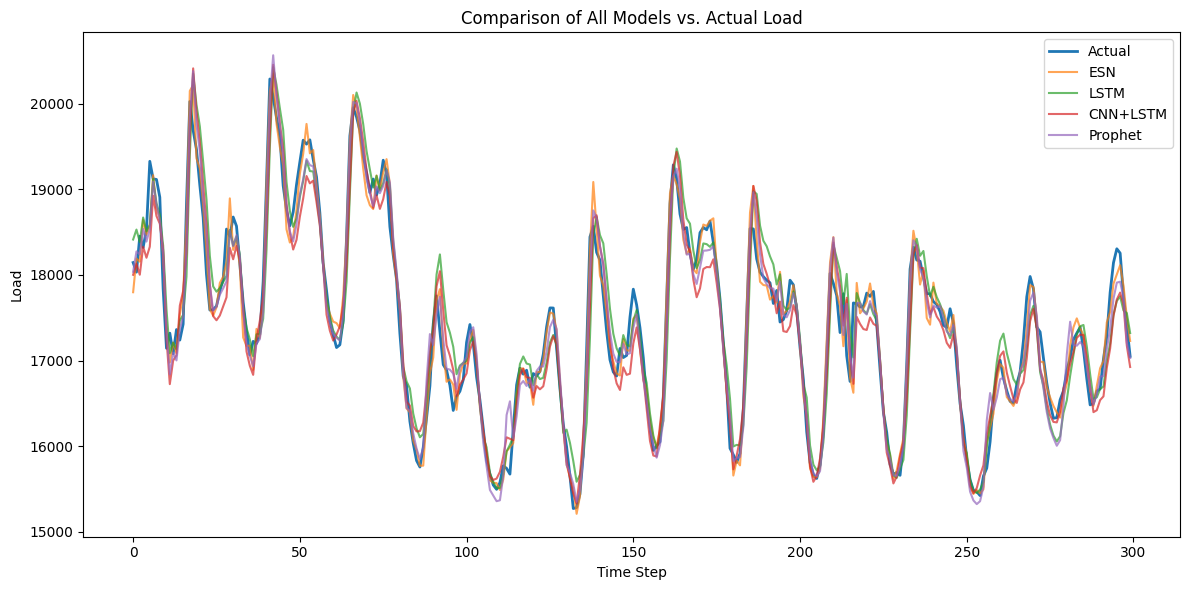

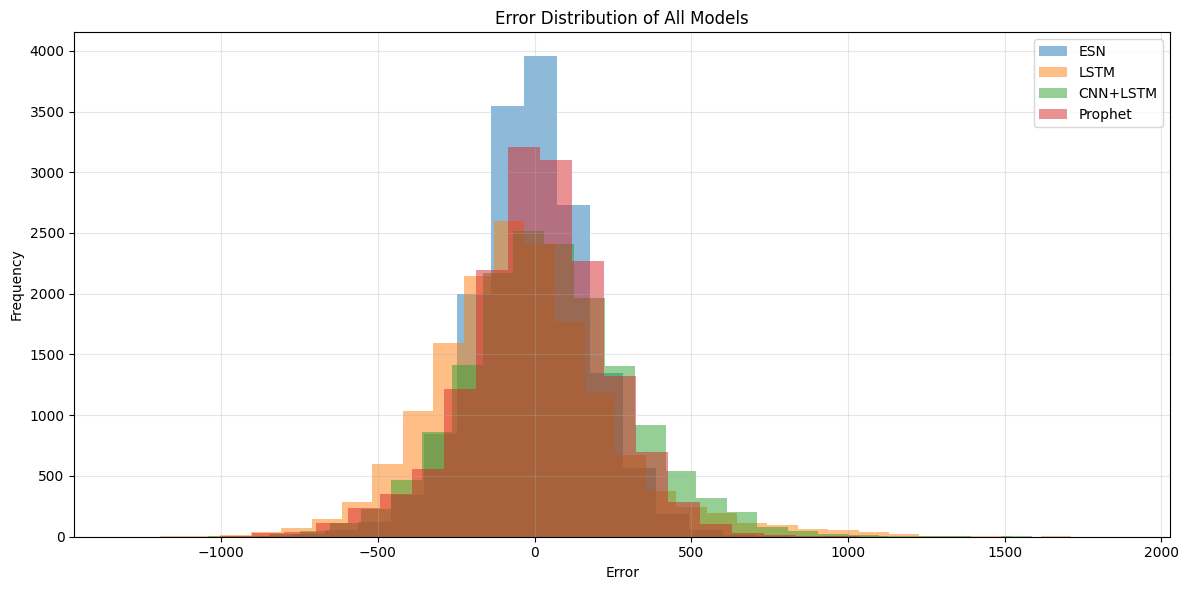

In [ ]:
##############################################################################
# 7) IMPROVED PROPHET MODEL IMPLEMENTATION
##############################################################################
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import warnings
import time
from joblib import Memory
from itertools import product
import random
from scipy.stats import ttest_rel

# Suppress prophet warnings
warnings.filterwarnings('ignore')

# Create joblib cache for prophet
prophet_memory = Memory(location="./joblib_cache", verbose=1)

def prepare_prophet_data(df, target_col='Actual Load', add_features=True):
    """
    Prepare data in the format required by Prophet (ds, y) with additional features
    """
    prophet_df = df[['Timestamp', target_col]].copy()
    prophet_df.columns = ['ds', 'y']
    
    # Add all the features used in your ESN model
    if add_features:
        # Time-based features - Prophet can handle these internally, but adding explicitly gives more control
        if 'Hour' in df.columns:
            prophet_df['hour'] = df['Hour']
        if 'Weekday' in df.columns:
            prophet_df['weekday'] = df['Weekday']
        if 'Month' in df.columns:
            prophet_df['month'] = df['Month']
            
        # Lag features - these are critical for load forecasting
        if 'Lag_1H' in df.columns:
            prophet_df['lag_1h'] = df['Lag_1H']
        if 'Lag_24H' in df.columns:
            prophet_df['lag_24h'] = df['Lag_24H']
            
        # If there's a weather forecast or temperature, add it too
        if 'Temperature' in df.columns:
            prophet_df['temperature'] = df['Temperature']
            
        # If you have any additional features, add them here
        additional_cols = [col for col in df.columns if col.startswith('Feature_')]
        for col in additional_cols:
            prophet_df[col.lower()] = df[col]
    
    return prophet_df

@prophet_memory.cache
def train_and_evaluate_prophet(
    df_train,
    df_test,
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=True,
    changepoint_prior_scale=0.05,
    seasonality_prior_scale=10.0,
    holidays_prior_scale=10.0,
    add_country_holidays=True,
    add_lag_features=True,
    fourier_order_yearly=10,
    fourier_order_weekly=5,
    fourier_order_daily=3,
    seed=42
):
    """
    Train Prophet model with advanced configuration and evaluate on test data
    """
    # Set random seed for reproducibility
    np.random.seed(seed)
    
    # Prepare data in prophet format with additional features
    train_prophet = prepare_prophet_data(df_train, add_features=add_lag_features)
    test_prophet = prepare_prophet_data(df_test, add_features=add_lag_features)
    
    # Create and train Prophet model with advanced configuration
    start_time = time.time()
    
    model = Prophet(
        yearly_seasonality=False,  # We'll add this with custom Fourier order
        weekly_seasonality=False,  # We'll add this with custom Fourier order
        daily_seasonality=False,   # We'll add this with custom Fourier order
        changepoint_prior_scale=changepoint_prior_scale,
        seasonality_prior_scale=seasonality_prior_scale,
        holidays_prior_scale=holidays_prior_scale,
        interval_width=0.95
    )
    
    # Add custom seasonalities with higher Fourier orders for better fit
    if yearly_seasonality:
        model.add_seasonality(name='yearly', period=365.25, fourier_order=fourier_order_yearly)
    
    if weekly_seasonality:
        model.add_seasonality(name='weekly', period=7, fourier_order=fourier_order_weekly)
    
    if daily_seasonality:
        model.add_seasonality(name='daily', period=1, fourier_order=fourier_order_daily)
    
    # Add country holidays if requested (often important for load forecasting)
    if add_country_holidays:
        model.add_country_holidays(country_name='NO')  # Change to appropriate country
        
    # Add lag features as regressors - these are CRITICAL for load forecasting
    if add_lag_features:
        if 'lag_1h' in train_prophet.columns:
            model.add_regressor('lag_1h')
        if 'lag_24h' in train_prophet.columns:
            model.add_regressor('lag_24h')
            
        # Add other features from your ESN model
        if 'hour' in train_prophet.columns:
            model.add_regressor('hour')
        if 'weekday' in train_prophet.columns:
            model.add_regressor('weekday')
        if 'month' in train_prophet.columns:
            model.add_regressor('month')
            
        # Add temperature if available
        if 'temperature' in train_prophet.columns:
            model.add_regressor('temperature')
            
        # Add any additional features
        additional_regressors = [col for col in train_prophet.columns 
                                if col.startswith('feature_')]
        for regressor in additional_regressors:
            model.add_regressor(regressor)
    
    # Fit the model
    model.fit(train_prophet)
    train_time = time.time() - start_time
    
    # Make predictions on test data
    future = test_prophet.copy()
    forecast = model.predict(future)
    
    # Extract predictions
    y_pred_prophet = forecast['yhat'].values.reshape(-1, 1)
    y_test = test_prophet['y'].values.reshape(-1, 1)
    
    # Compute metrics
    mae = mean_absolute_error(y_test, y_pred_prophet)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_prophet))
    mape = np.mean(np.abs((y_test - y_pred_prophet) / y_test)) * 100
    r2 = r2_score(y_test, y_pred_prophet)
    
    metrics = {
        'mae': mae,
        'rmse': rmse,
        'mape': mape,
        'r2': r2,
        'preds': y_pred_prophet,
        'train_time': train_time,
        'forecast': forecast  # Save full forecast for component plots
    }
    
    return metrics, model

# ---------------------------------------------------------------------------
# 7.1) Enhanced Prophet Hyperparameter Search
# ---------------------------------------------------------------------------

# Define enhanced parameter grid for Prophet
prophet_param_grid = {
    'yearly_seasonality': [True],
    'weekly_seasonality': [True],
    'daily_seasonality': [True],
    'changepoint_prior_scale': [0.001, 0.01, 0.05, 0.1],
    'seasonality_prior_scale': [0.1, 1.0, 10.0],
    'holidays_prior_scale': [1.0, 10.0],
    'add_country_holidays': [True],
    'add_lag_features': [True],
    'fourier_order_yearly': [10, 20],
    'fourier_order_weekly': [5, 10],
    'fourier_order_daily': [3, 5, 10]
}

def run_prophet_search(n_iter=20):
    """
    Run hyperparameter search for Prophet model with random search
    """
    print("\n--- IMPROVED PROPHET HYPERPARAM SEARCH ---")
    
    # Get all parameter combinations
    param_names = list(prophet_param_grid.keys())
    
    # Use random search instead of grid search to explore more effectively
    best_mape = float('inf')
    best_params = None
    best_metrics = None
    
    # Generate random parameter combinations
    random.seed(42)
    param_combinations = []
    for _ in range(n_iter):
        param_combo = {
            'yearly_seasonality': random.choice(prophet_param_grid['yearly_seasonality']),
            'weekly_seasonality': random.choice(prophet_param_grid['weekly_seasonality']),
            'daily_seasonality': random.choice(prophet_param_grid['daily_seasonality']),
            'changepoint_prior_scale': random.choice(prophet_param_grid['changepoint_prior_scale']),
            'seasonality_prior_scale': random.choice(prophet_param_grid['seasonality_prior_scale']),
            'holidays_prior_scale': random.choice(prophet_param_grid['holidays_prior_scale']),
            'add_country_holidays': random.choice(prophet_param_grid['add_country_holidays']),
            'add_lag_features': random.choice(prophet_param_grid['add_lag_features']),
            'fourier_order_yearly': random.choice(prophet_param_grid['fourier_order_yearly']),
            'fourier_order_weekly': random.choice(prophet_param_grid['fourier_order_weekly']),
            'fourier_order_daily': random.choice(prophet_param_grid['fourier_order_daily'])
        }
        param_combinations.append(param_combo)
    
    # Try a few hand-tuned combinations that typically work well for load forecasting
    param_combinations.append({
        'yearly_seasonality': True,
        'weekly_seasonality': True,
        'daily_seasonality': True,
        'changepoint_prior_scale': 0.01,
        'seasonality_prior_scale': 10.0,
        'holidays_prior_scale': 10.0,
        'add_country_holidays': True,
        'add_lag_features': True,
        'fourier_order_yearly': 20,
        'fourier_order_weekly': 10,
        'fourier_order_daily': 10
    })
    
    # Always include the configuration with lag features
    param_combinations.append({
        'yearly_seasonality': True,
        'weekly_seasonality': True,
        'daily_seasonality': True,
        'changepoint_prior_scale': 0.01,
        'seasonality_prior_scale': 1.0,
        'holidays_prior_scale': 1.0,
        'add_country_holidays': True,
        'add_lag_features': True,
        'fourier_order_yearly': 10,
        'fourier_order_weekly': 5,
        'fourier_order_daily': 5
    })
    
    for i, params in enumerate(param_combinations):
        print(f"Prophet config {i+1}/{len(param_combinations)}: {params}")
        
        try:
            metrics, _ = train_and_evaluate_prophet(
                df_train=df_train,
                df_test=df_test,
                **params
            )
            
            print(f" -> MAPE={metrics['mape']:.2f}%, MAE={metrics['mae']:.2f}, RMSE={metrics['rmse']:.2f}, Train Time={metrics['train_time']:.2f}s")
            
            if metrics['mape'] < best_mape:
                best_mape = metrics['mape']
                best_params = params.copy()
                best_metrics = metrics.copy()
        except Exception as e:
            print(f" -> Error with this configuration: {str(e)}")
            continue
    
    print("\nBEST PROPHET PARAMS:", best_params)
    print(f"BEST METRICS: MAPE={best_metrics['mape']:.2f}%, MAE={best_metrics['mae']:.2f}, RMSE={best_metrics['rmse']:.2f}")
    
    return best_params, best_metrics

# ---------------------------------------------------------------------------
# 7.2) Train Final Prophet Model with Best Parameters
# ---------------------------------------------------------------------------

def train_final_prophet_model(best_params):
    """
    Train final Prophet model with best parameters
    """
    print("\n--- Training FINAL IMPROVED PROPHET MODEL ---")
    
    # Train Prophet with best params
    metrics, model = train_and_evaluate_prophet(
        df_train=df_train,
        df_test=df_test,
        **best_params
    )
    
    y_pred_prophet_final = metrics['preds']
    forecast = metrics['forecast']
    
    print(f"FINAL PROPHET => MAE={metrics['mae']:.2f}, RMSE={metrics['rmse']:.2f}, MAPE={metrics['mape']:.2f}%, Train Time={metrics['train_time']:.2f}s")
    
    return y_pred_prophet_final, model, forecast

# ---------------------------------------------------------------------------
# 7.3) Plot Prophet Components and Feature Importances
# ---------------------------------------------------------------------------

def plot_prophet_components(model, forecast):
    """
    Plot Prophet forecast components
    """
    fig = model.plot_components(forecast)
    plt.tight_layout()
    plt.savefig('prophet_components.png', dpi=300)
    plt.close()
    
    # Plot forecast vs actual
    fig = model.plot(forecast)
    plt.tight_layout()
    plt.savefig('prophet_forecast.png', dpi=300)
    plt.close()
    
    # If there are regressor components, visualize their importance
    regressor_names = [name for name in forecast.columns if name.startswith('trend_') or 
                       (name not in ['ds', 'trend', 'yhat', 'yhat_lower', 'yhat_upper', 
                                   'trend_lower', 'trend_upper', 'additive_terms', 
                                   'additive_terms_lower', 'additive_terms_upper',
                                   'weekly', 'weekly_lower', 'weekly_upper',
                                   'yearly', 'yearly_lower', 'yearly_upper',
                                   'daily', 'daily_lower', 'daily_upper',
                                   'multiplicative_terms', 'multiplicative_terms_lower',
                                   'multiplicative_terms_upper'])]
    
    if regressor_names:
        plt.figure(figsize=(10, 6))
        for name in regressor_names:
            plt.plot(forecast['ds'], forecast[name], label=name)
        plt.legend()
        plt.title('Regressor Components in Prophet Model')
        plt.xlabel('Date')
        plt.tight_layout()
        plt.savefig('prophet_regressors.png', dpi=300)
        plt.close()

# ---------------------------------------------------------------------------
# 7.4) Update Final Comparison & Plots to Include Improved Prophet
# ---------------------------------------------------------------------------

def update_final_comparison(y_test_final, y_pred_final, y_pred_lstm_final,
                          y_pred_cnnlstm_final, y_pred_prophet_final):
    """
    Update final comparison to include improved Prophet and error results.
    """
    def compute_metrics(y_true, y_pred):
        mae = np.mean(np.abs(y_true - y_pred))
        rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
        mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
        r2 = r2_score(y_true, y_pred)
        errors = y_true - y_pred  # Calculate errors
        return mae, rmse, mape, r2, errors

    # Compute metrics and errors for all models
    mae_esn, rmse_esn, mape_esn, r2_esn, esn_errors = compute_metrics(y_test_final, y_pred_final)
    mae_lstm, rmse_lstm, mape_lstm, r2_lstm, lstm_errors = compute_metrics(y_test_final, y_pred_lstm_final)
    mae_cnn, rmse_cnn, mape_cnn, r2_cnn, cnn_errors = compute_metrics(y_test_final, y_pred_cnnlstm_final)
    mae_prophet, rmse_prophet, mape_prophet, r2_prophet, prophet_errors = compute_metrics(y_test_final, y_pred_prophet_final)

    print("\nFINAL COMPARISON (ALL MODELS):")
    print(f"ESN     => MAE={mae_esn:.2f},     RMSE={rmse_esn:.2f},     MAPE={mape_esn:.2f}%,    R2={r2_esn:.4f}")
    print(f"LSTM    => MAE={mae_lstm:.2f},    RMSE={rmse_lstm:.2f},    MAPE={mape_lstm:.2f}%,   R2={r2_lstm:.4f}")
    print(f"CNN+LSTM=> MAE={mae_cnn:.2f},     RMSE={rmse_cnn:.2f},     MAPE={mape_cnn:.2f}%,    R2={r2_cnn:.4f}")
    print(f"PROPHET => MAE={mae_prophet:.2f}, RMSE={rmse_prophet:.2f}, MAPE={mape_prophet:.2f}%, R2={r2_prophet:.4f}")

    # Create comparative table
    results_df = pd.DataFrame({
        'Model': ['ESN', 'LSTM', 'CNN+LSTM', 'Prophet'],
        'MAE': [mae_esn, mae_lstm, mae_cnn, mae_prophet],
        'RMSE': [rmse_esn, rmse_lstm, rmse_cnn, rmse_prophet],
        'MAPE (%)': [mape_esn, mape_lstm, mape_cnn, mape_prophet],
        'R²': [r2_esn, r2_lstm, r2_cnn, r2_prophet],
        'Errors': [esn_errors.flatten(), lstm_errors.flatten(), cnn_errors.flatten(), prophet_errors.flatten()]  # Add errors
    })

    # Sort by MAPE (lower is better)
    results_df = results_df.sort_values('MAPE (%)')

    print("\nRanked Model Performance:")
    print(results_df)

    # Print error results
    print("\nError Results:")
    print("ESN Errors:", esn_errors.flatten())
    print("LSTM Errors:", lstm_errors.flatten())
    print("CNN+LSTM Errors:", cnn_errors.flatten())
    print("Prophet Errors:", prophet_errors.flatten())

    # Paired t-tests to compare models
    from scipy.stats import ttest_rel
    
    # Compare Prophet vs ESN
    prophet_errors = np.abs(y_test_final - y_pred_prophet_final).flatten()
    esn_errors = np.abs(y_test_final - y_pred_final).flatten()
    t_stat_esn, p_val_esn = ttest_rel(prophet_errors, esn_errors)
    print(f"\nPaired t-test Prophet vs. ESN: t={t_stat_esn:.3f}, p-value={p_val_esn:.4f}")
    
    # Compare Prophet vs LSTM
    lstm_errors = np.abs(y_test_final - y_pred_lstm_final).flatten()
    t_stat_lstm, p_val_lstm = ttest_rel(prophet_errors, lstm_errors)
    print(f"Paired t-test Prophet vs. LSTM: t={t_stat_lstm:.3f}, p-value={p_val_lstm:.4f}")
    
    # Compare Prophet vs CNN+LSTM
    cnn_errors = np.abs(y_test_final - y_pred_cnnlstm_final).flatten() 
    t_stat_cnn, p_val_cnn = ttest_rel(prophet_errors, cnn_errors)
    print(f"Paired t-test Prophet vs. CNN+LSTM: t={t_stat_cnn:.3f}, p-value={p_val_cnn:.4f}")

def plot_all_models(y_test_final, y_pred_final, y_pred_lstm_final, 
                   y_pred_cnnlstm_final, y_pred_prophet_final,
                   max_plot=300):
    """
    Plot all model predictions
    """
    plt.figure(figsize=(12, 6))
    plt.plot(y_test_final[:max_plot], label='Actual', linewidth=2)
    plt.plot(y_pred_final[:max_plot], label='ESN', alpha=0.7)
    plt.plot(y_pred_lstm_final[:max_plot], label='LSTM', alpha=0.7)
    plt.plot(y_pred_cnnlstm_final[:max_plot], label='CNN+LSTM', alpha=0.7)
    plt.plot(y_pred_prophet_final[:max_plot], label='Prophet', alpha=0.7)

    plt.title('Comparison of All Models vs. Actual Load')
    plt.xlabel('Time Step')
    plt.ylabel('Load')
    plt.legend()
    plt.tight_layout()
    plt.savefig('all_models_comparison.png', dpi=300)
    plt.show()
    
    # Plot error distribution
    plt.figure(figsize=(12, 6))
    
    # Calculate errors
    esn_err = (y_test_final - y_pred_final).flatten()
    lstm_err = (y_test_final - y_pred_lstm_final).flatten()
    cnn_err = (y_test_final - y_pred_cnnlstm_final).flatten()
    prophet_err = (y_test_final - y_pred_prophet_final).flatten()
    
    # Plot histograms
    plt.hist(esn_err, bins=30, alpha=0.5, label='ESN')
    plt.hist(lstm_err, bins=30, alpha=0.5, label='LSTM')
    plt.hist(cnn_err, bins=30, alpha=0.5, label='CNN+LSTM')
    plt.hist(prophet_err, bins=30, alpha=0.5, label='Prophet')
    
    plt.title('Error Distribution of All Models')
    plt.xlabel('Error')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('error_distribution.png', dpi=300)
    plt.show()

##############################################################################
# 8) MAIN EXECUTION FLOW
##############################################################################

if __name__ == "__main__":
    # Assuming df_train, df_test, y_test_final, y_pred_final, y_pred_lstm_final, y_pred_cnnlstm_final are defined
    # Run improved Prophet hyperparameter search - use a smaller number like 10-20 for faster results
    best_prophet_params, best_prophet_metrics = run_prophet_search(n_iter=15)
    
    # Train final Prophet model
    y_pred_prophet_final, prophet_model, prophet_forecast = train_final_prophet_model(best_prophet_params)
    
    # Plot Prophet components
    plot_prophet_components(prophet_model, prophet_forecast)
    
    # Update final comparison to include improved Prophet
    update_final_comparison(
        y_test_final, 
        y_pred_final, 
        y_pred_lstm_final, 
        y_pred_cnnlstm_final, 
        y_pred_prophet_final
    )
    
    # Plot all models together
    plot_all_models(
        y_test_final, 
        y_pred_final, 
        y_pred_lstm_final, 
        y_pred_cnnlstm_final, 
        y_pred_prophet_final
    )

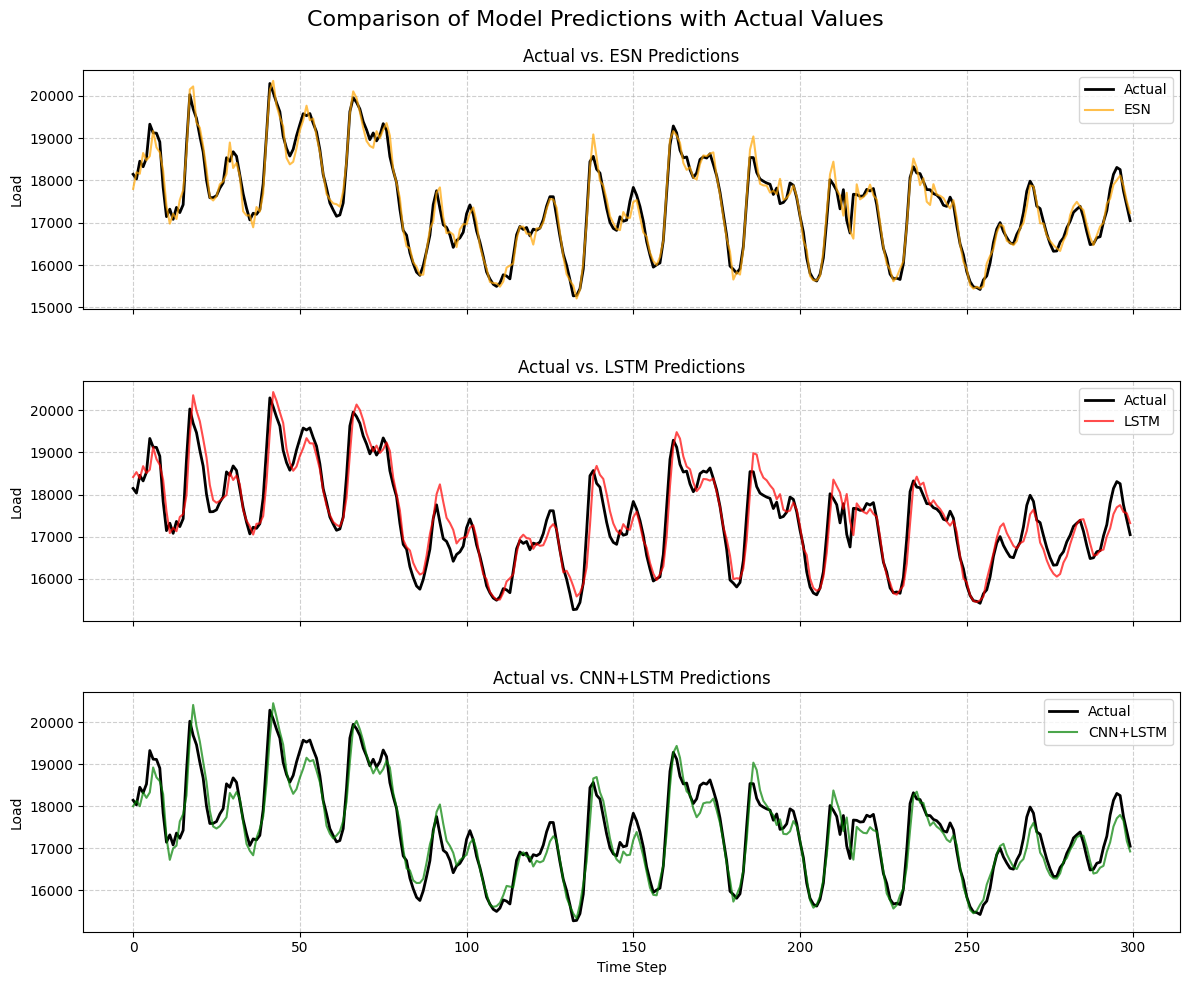

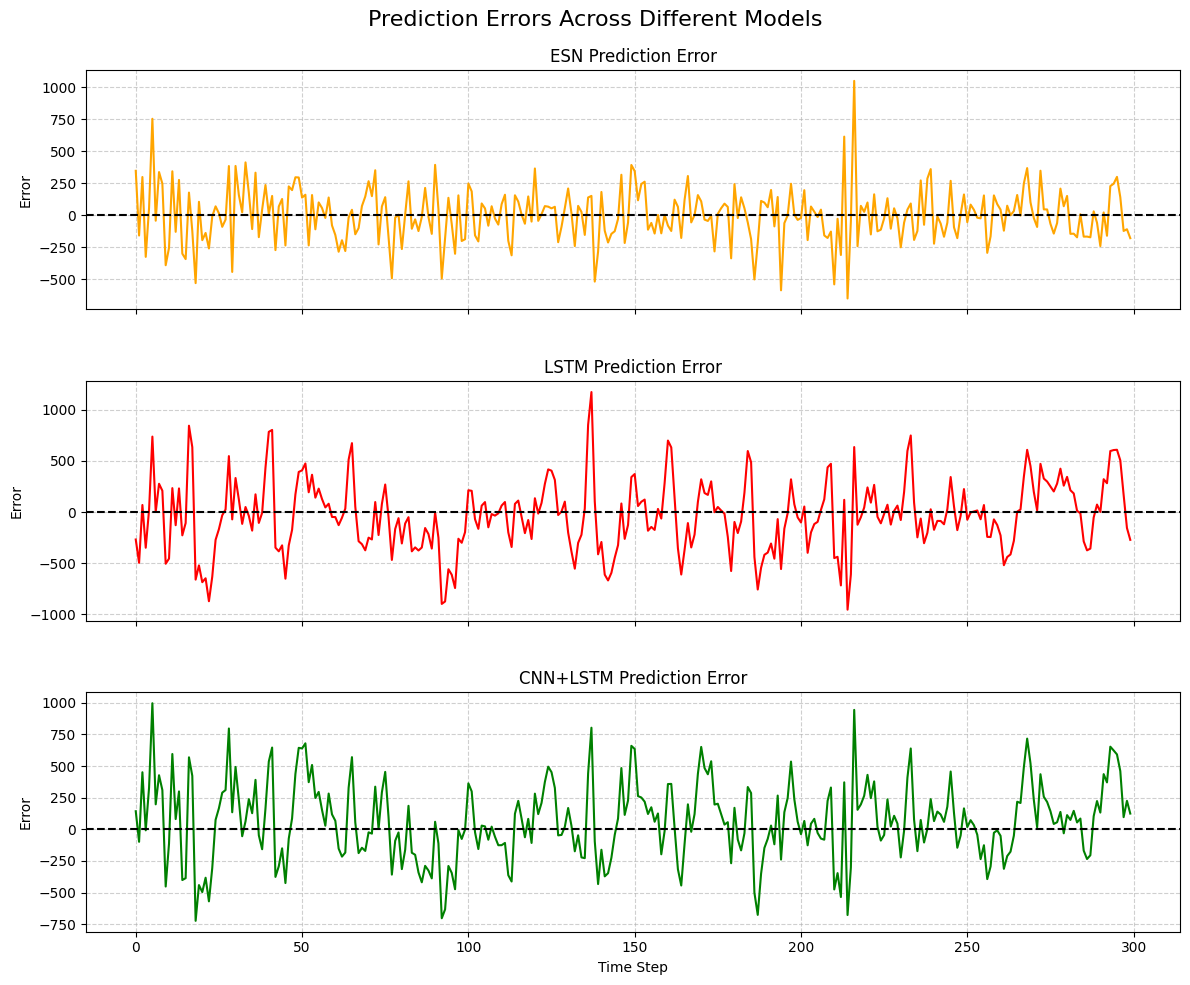

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming we have these variables from the provided code:
# y_test_final - The actual target values
# y_pred_final - Predictions from ESN model
# y_pred_lstm_final - Predictions from LSTM model
# y_pred_cnnlstm_final - Predictions from CNN+LSTM model

max_plot = 300  # Number of test points to visualize

# Create figure and subplots with shared x-axis
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

# Plot 1: Comparison of Actual vs. ESN
ax1.plot(y_test_final[:max_plot], label='Actual', linewidth=2, color='black')
ax1.plot(y_pred_final[:max_plot], label='ESN', alpha=0.7, color='orange')
ax1.set_title('Actual vs. ESN Predictions')
ax1.set_ylabel('Load')
ax1.legend(loc='upper right')
ax1.grid(True, linestyle='--', alpha=0.6)

# Plot 2: Comparison of Actual vs. LSTM
ax2.plot(y_test_final[:max_plot], label='Actual', linewidth=2, color='black')
ax2.plot(y_pred_lstm_final[:max_plot], label='LSTM', alpha=0.7, color='red')
ax2.set_title('Actual vs. LSTM Predictions')
ax2.set_ylabel('Load')
ax2.legend(loc='upper right')
ax2.grid(True, linestyle='--', alpha=0.6)

# Plot 3: Comparison of Actual vs. CNN+LSTM
ax3.plot(y_test_final[:max_plot], label='Actual', linewidth=2, color='black')
ax3.plot(y_pred_cnnlstm_final[:max_plot], label='CNN+LSTM', alpha=0.7, color='green')
ax3.set_title('Actual vs. CNN+LSTM Predictions')
ax3.set_xlabel('Time Step')
ax3.set_ylabel('Load')
ax3.legend(loc='upper right')
ax3.grid(True, linestyle='--', alpha=0.6)

# Add a bit of space between subplots for titles
plt.subplots_adjust(hspace=0.3)

# Add a main title for the entire figure
fig.suptitle('Comparison of Model Predictions with Actual Values', fontsize=16, y=0.98)

# Show the plot
plt.tight_layout()
plt.subplots_adjust(top=0.92, hspace=0.3)  # Adjust top to make room for suptitle and add space between plots
plt.show()

# Alternative Version: Error Plots
# This version shows the prediction errors (difference between actual and predicted)
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

# Plot 1: ESN Error
error_esn = y_test_final[:max_plot] - y_pred_final[:max_plot]
ax1.plot(error_esn, color='orange')
ax1.axhline(y=0, color='black', linestyle='--')
ax1.set_title('ESN Prediction Error')
ax1.set_ylabel('Error')
ax1.grid(True, linestyle='--', alpha=0.6)

# Plot 2: LSTM Error
error_lstm = y_test_final[:max_plot] - y_pred_lstm_final[:max_plot]
ax2.plot(error_lstm, color='red')
ax2.axhline(y=0, color='black', linestyle='--')
ax2.set_title('LSTM Prediction Error')
ax2.set_ylabel('Error')
ax2.grid(True, linestyle='--', alpha=0.6)

# Plot 3: CNN+LSTM Error
error_cnnlstm = y_test_final[:max_plot] - y_pred_cnnlstm_final[:max_plot]
ax3.plot(error_cnnlstm, color='green')
ax3.axhline(y=0, color='black', linestyle='--')
ax3.set_title('CNN+LSTM Prediction Error')
ax3.set_xlabel('Time Step')
ax3.set_ylabel('Error')
ax3.grid(True, linestyle='--', alpha=0.6)

# Add a bit of space between subplots for titles
plt.subplots_adjust(hspace=0.3)

# Add a main title for the entire figure
fig.suptitle('Prediction Errors Across Different Models', fontsize=16, y=0.98)

# Show the plot
plt.tight_layout()
plt.subplots_adjust(top=0.92, hspace=0.3)  # Adjust top to make room for suptitle and add space between plots
plt.show()

Residuals Over Time

If the residuals (Actual - Predicted) mostly hover around zero with no consistent positive or negative drift, it means the model isn’t chronically under- or overestimating at certain times.

Occasional spikes in residuals are normal in time-series forecasting, but if you see large spikes at specific repeating intervals (e.g., every day at the same hour), the model might be missing a regular pattern.

Histograms of Residuals

A symmetric distribution with a center near zero typically indicates the model predictions are unbiased overall.

A long tail on one side might suggest the model tends to systematically under-predict or over-predict in certain scenarios (e.g., especially high loads).

A narrower distribution means more data points have small errors, which is good.

Comparing ESN vs. LSTM vs. CNN+LSTM

Ideally, your ESN residuals should be tighter around zero (narrower histogram) if ESN is truly performing better (lower MAPE, etc.).

If the LSTM or CNN+LSTM histograms appear more spread out, that implies more frequent or larger errors.

On a time-series residual plot, if one model shows more structured patterns (like cyclical waves in residuals), it might be systematically missing certain time-of-day or seasonal behaviors.

If You See
Mostly random scatter of residuals around 0 with no obvious pattern:
This indicates your model is capturing most of the periodic/seasonal structure and is not systematically biased.

Symmetric, fairly peaked histogram around 0:
This suggests a lot of predictions are very close to the actual values, and extreme misses are fewer.

A slight bias (the residual mean is positive or negative) or a skewed histogram:
Might mean the model tends to over-predict or under-predict. You can investigate whether adding or adjusting features (e.g., more lags, other exogenous data) helps.

Overall
A “good” set of residual plots will show residuals mostly centered near zero with no major patterns that repeat over time.

From your final reported metrics (MAE, MAPE, RMSE, and the test predictions), it sounds like your ESN is already performing very well and generally outperforms LSTM/CNN+LSTM.

If the residual plots confirm minimal bias and no consistent patterns in the errors, that further strengthens the conclusion that your ESN is capturing the main load dynamics effectively.

## For ESN residuals plot: 
The residuals hover around zero with both positive and negative excursions, which suggests that on average the model is neither drastically underestimating nor overestimating.

No obvious repeating pattern or drift:

You see spikes in both positive and negative directions, but there’s no persistent trend where the model consistently undershoots or overshoots at a particular interval.

This generally indicates the ESN is capturing major cyclic or seasonal components of the data without a clear systematic bias.

Occasional big spikes (e.g., around +900 or −600) are fairly common in load forecasting because short-term demand can fluctuate due to unforeseen events, temperature extremes, or other transient factors the model can’t perfectly capture.

Overall, it looks good: the residual line fluctuates randomly around the horizontal zero line. While no model is perfect, and occasional large errors will happen, the lack of a strong bias or repetitive pattern in the residuals suggests the ESN is doing a decent job capturing the main load dynamics.








## Model Comparison Boxplots 

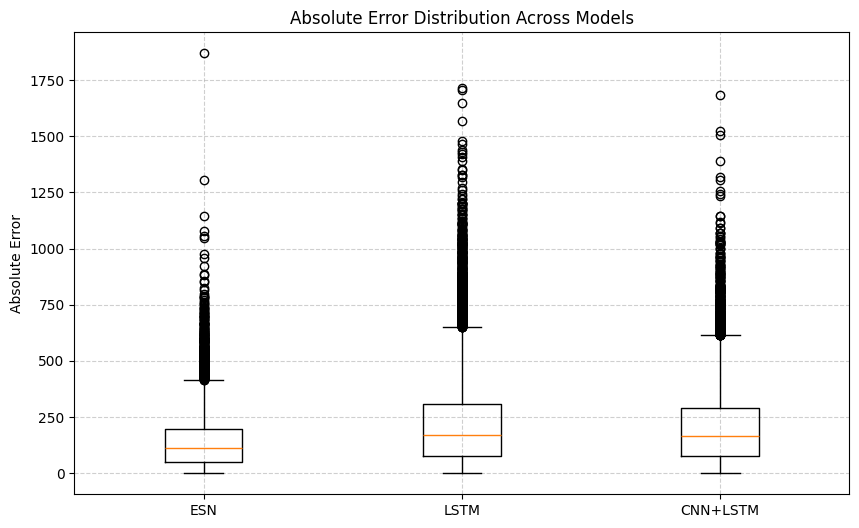

In [20]:
plt.figure(figsize=(10, 6))
error_data = [
    np.abs(y_test_final - y_pred_final).flatten(),
    np.abs(y_test_final - y_pred_lstm_final).flatten(),
    np.abs(y_test_final - y_pred_cnnlstm_final).flatten()
]
plt.boxplot(error_data, labels=['ESN', 'LSTM', 'CNN+LSTM'])
plt.title('Absolute Error Distribution Across Models')
plt.ylabel('Absolute Error')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

## Scatterplot of Actual vs Predicted 

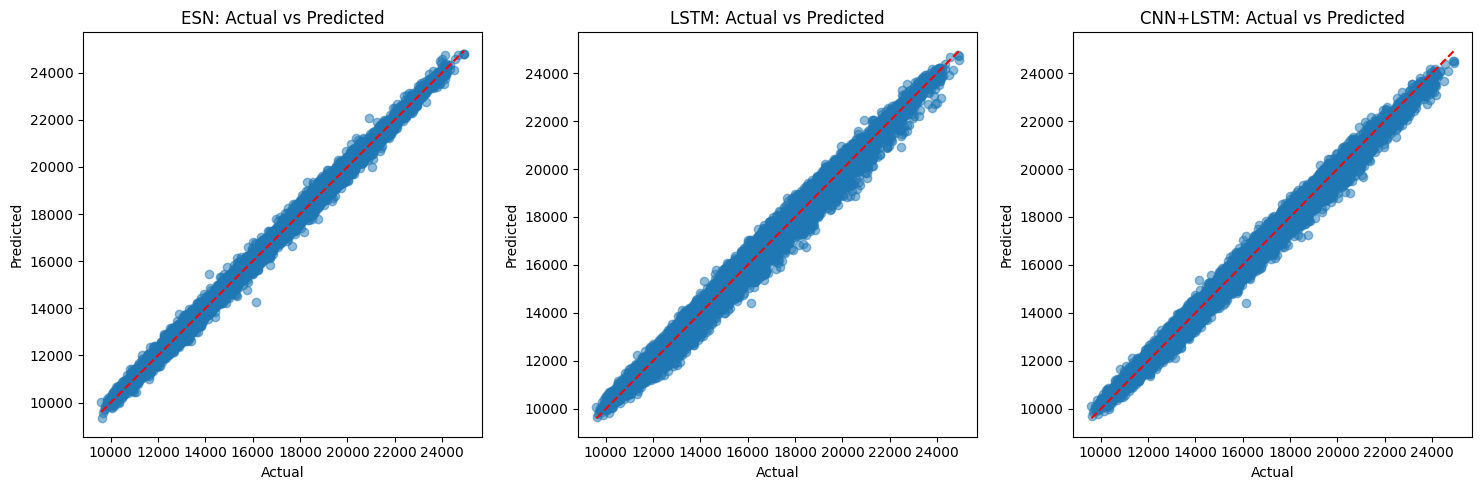

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].scatter(y_test_final, y_pred_final, alpha=0.5)
axes[0].plot([min(y_test_final), max(y_test_final)], [min(y_test_final), max(y_test_final)], 'r--')
axes[0].set_title('ESN: Actual vs Predicted')
axes[0].set_xlabel('Actual')
axes[0].set_ylabel('Predicted')

axes[1].scatter(y_test_final, y_pred_lstm_final, alpha=0.5)
axes[1].plot([min(y_test_final), max(y_test_final)], [min(y_test_final), max(y_test_final)], 'r--')
axes[1].set_title('LSTM: Actual vs Predicted')
axes[1].set_xlabel('Actual')
axes[1].set_ylabel('Predicted')

axes[2].scatter(y_test_final, y_pred_cnnlstm_final, alpha=0.5)
axes[2].plot([min(y_test_final), max(y_test_final)], [min(y_test_final), max(y_test_final)], 'r--')
axes[2].set_title('CNN+LSTM: Actual vs Predicted')
axes[2].set_xlabel('Actual')
axes[2].set_ylabel('Predicted')

plt.tight_layout()
plt.show()

## Histogram of Errors

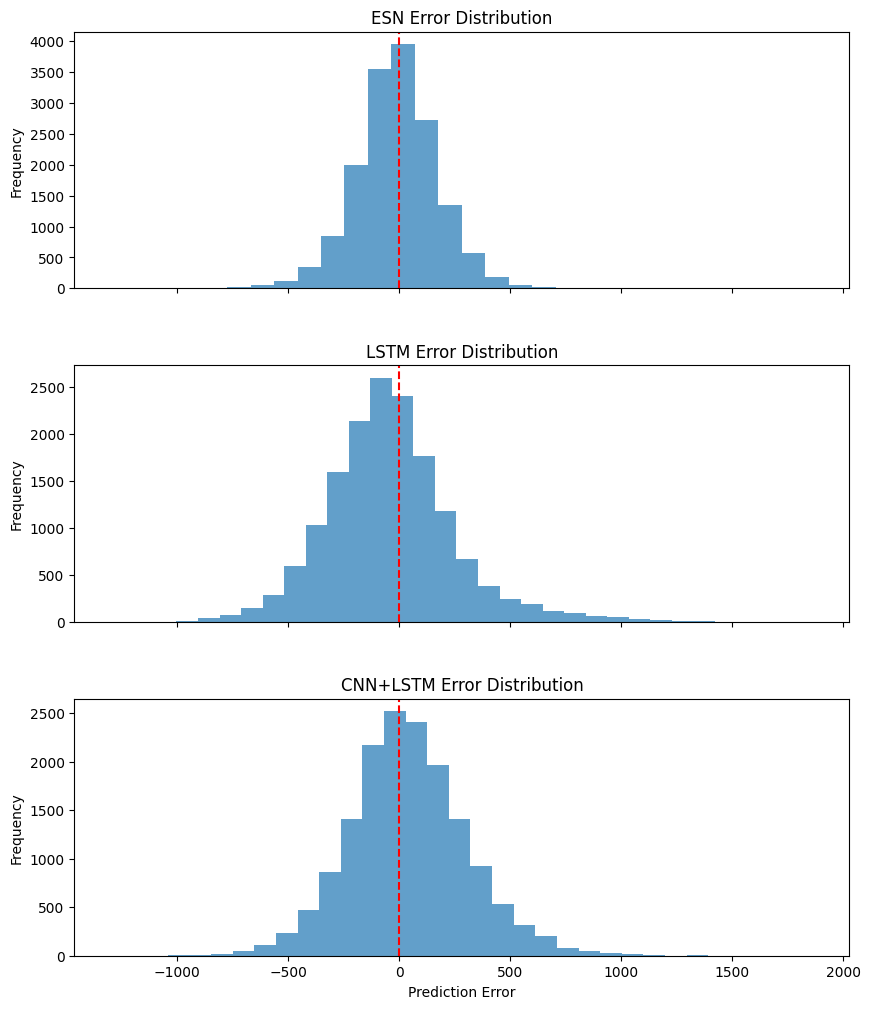

In [22]:
fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

axes[0].hist(y_test_final - y_pred_final, bins=30, alpha=0.7)
axes[0].set_title('ESN Error Distribution')
axes[0].axvline(x=0, color='r', linestyle='--')
axes[0].set_ylabel('Frequency')

axes[1].hist(y_test_final - y_pred_lstm_final, bins=30, alpha=0.7)
axes[1].set_title('LSTM Error Distribution')
axes[1].axvline(x=0, color='r', linestyle='--')
axes[1].set_ylabel('Frequency')

axes[2].hist(y_test_final - y_pred_cnnlstm_final, bins=30, alpha=0.7)
axes[2].set_title('CNN+LSTM Error Distribution')
axes[2].axvline(x=0, color='r', linestyle='--')
axes[2].set_xlabel('Prediction Error')
axes[2].set_ylabel('Frequency')

plt.subplots_adjust(hspace=0.3)
plt.show()

## Autocorrelation of Errors

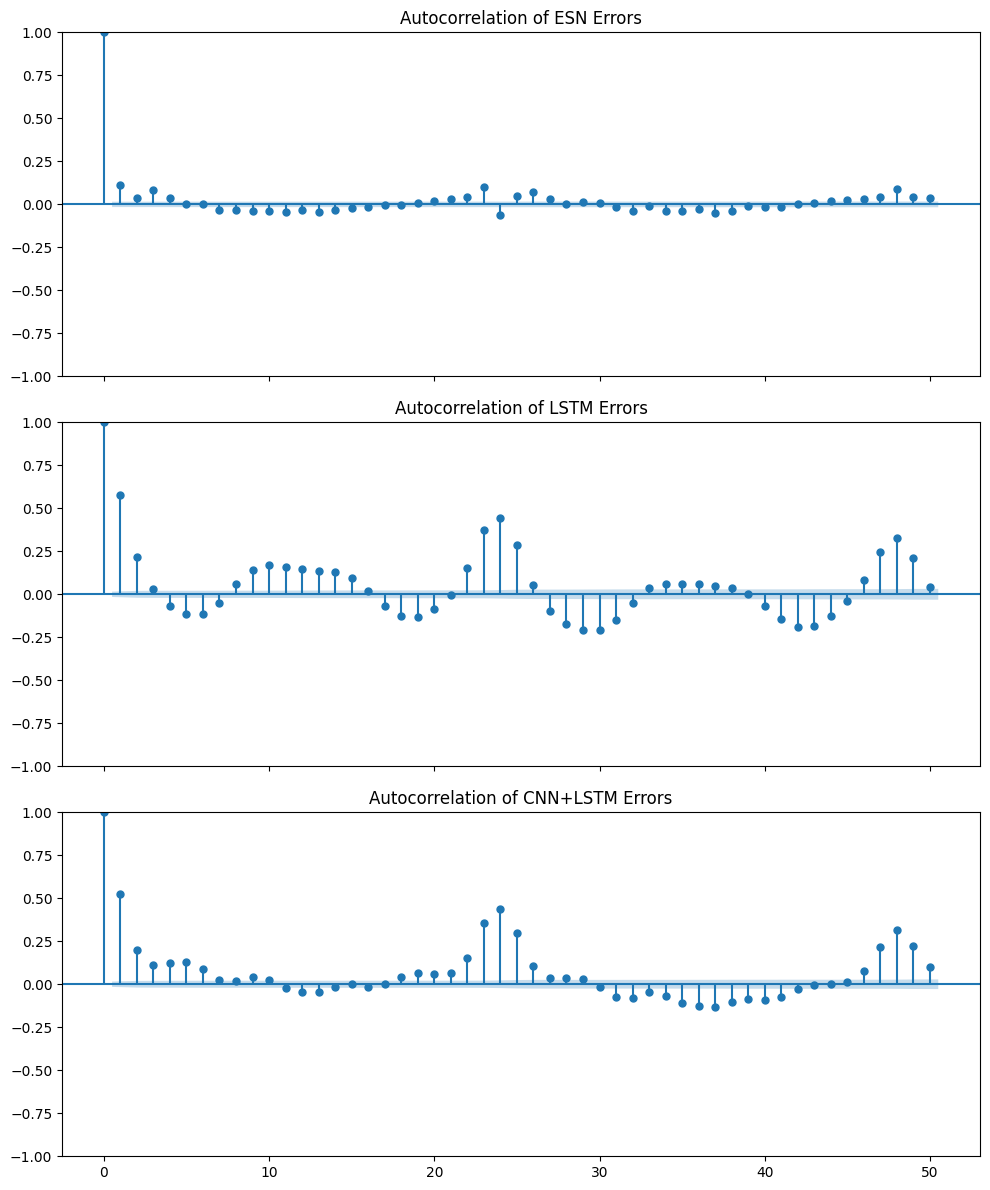

In [23]:
from statsmodels.graphics.tsaplots import plot_acf

fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

plot_acf(y_test_final - y_pred_final, ax=axes[0], lags=50)
axes[0].set_title('Autocorrelation of ESN Errors')

plot_acf(y_test_final - y_pred_lstm_final, ax=axes[1], lags=50)
axes[1].set_title('Autocorrelation of LSTM Errors')

plot_acf(y_test_final - y_pred_cnnlstm_final, ax=axes[2], lags=50)
axes[2].set_title('Autocorrelation of CNN+LSTM Errors')

plt.subplots_adjust(hspace=0.3)
plt.tight_layout()
plt.show()

## Performance Metrics Radar Chart

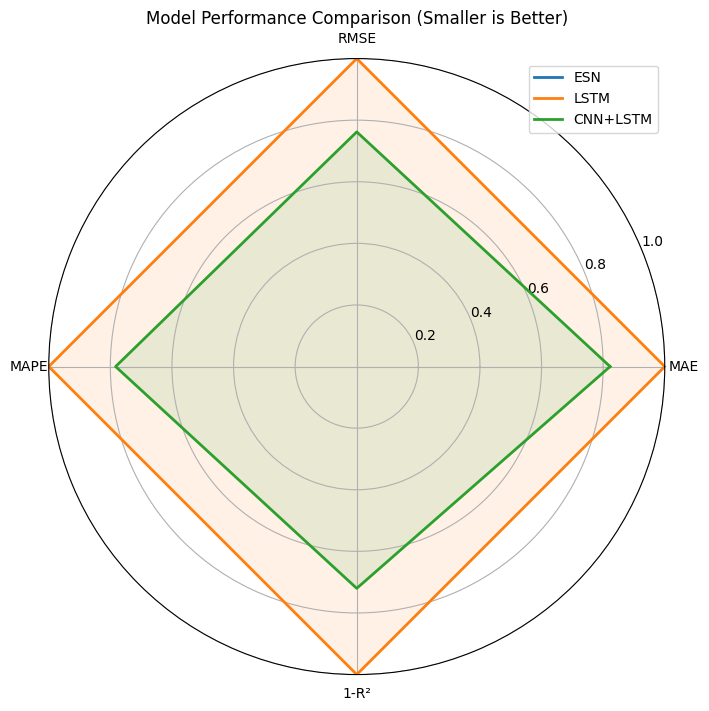

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Metrics from your final comparison
metrics = {
    'ESN': [mae_esn, rmse_esn, mape_esn, 1-r2_esn],  # Note: Using 1-R² so smaller is better for all metrics
    'LSTM': [mae_lstmF, rmse_lstmF, mape_lstmF, 1-r2_lstmF],
    'CNN+LSTM': [mae_cnnF, rmse_cnnF, mape_cnnF, 1-r2_cnnF]
}

# Normalize metrics to 0-1 scale for the radar chart
labels = ['MAE', 'RMSE', 'MAPE', '1-R²']
metrics_norm = {}
for model, vals in metrics.items():
    # Normalize to 0-1 where 0 is the best score across models for that metric
    metrics_norm[model] = []
    for i, val in enumerate(vals):
        min_val = min(metrics['ESN'][i], metrics['LSTM'][i], metrics['CNN+LSTM'][i])
        max_val = max(metrics['ESN'][i], metrics['LSTM'][i], metrics['CNN+LSTM'][i])
        range_val = max_val - min_val
        if range_val == 0:
            metrics_norm[model].append(0)
        else:
            metrics_norm[model].append((val - min_val) / range_val)

# Plot
angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False).tolist()
angles += angles[:1]  # Close the loop

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
for model, vals in metrics_norm.items():
    vals += vals[:1]  # Close the loop
    ax.plot(angles, vals, linewidth=2, label=model)
    ax.fill(angles, vals, alpha=0.1)

ax.set_thetagrids(np.degrees(angles[:-1]), labels)
ax.set_ylim(0, 1)
ax.set_title('Model Performance Comparison (Smaller is Better)')
ax.legend(loc='upper right')
plt.show()